In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from data_cleansing import Wrangling_data
from custom_transformer import Streak_score_wavg, GD_weight_avg, Calculate_ELO_point, Data_Wrangling, Features_chosen, Cal_Team_Performance
from database import SQLiteDBManager
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np


# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn import set_config
# listing model 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB, MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from supreme_cross_validation import HyperclassifierSearch

# pipline
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Normalize data 
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler

# imbalance data
from imblearn.over_sampling import  SMOTE, RandomOverSampler
from sklearn.model_selection import RepeatedStratifiedKFold

# Save model
import pickle
import joblib
import os
import time
from datetime import datetime

# Visual the confusion matrix
import matplotlib.pyplot as plt
from pytz import timezone
import random

In [3]:
import warnings

# Filter or ignore specific warning category
warnings.filterwarnings("ignore")

# Train Data

## Export file

In [4]:
path = 'C:/Users/user2/PycharmProjects/selenium_scraping_match/data'
path

'C:/Users/user2/PycharmProjects/selenium_scraping_match/data'

In [5]:
pwd

'C:\\Users\\user2\\PycharmProjects\\customTransformer'

In [6]:
data_list = [os.path.join(path,file) for file in os.listdir(path) if os.path.splitext(file)[-1] == '.csv']
data_list

["C:/Users/user2/PycharmProjects/selenium_scraping_match/data\\2019 FIFA Women's World Cup_detail_match.csv",
 'C:/Users/user2/PycharmProjects/selenium_scraping_match/data\\2021 Friendlies (W)_detail_match.csv',
 'C:/Users/user2/PycharmProjects/selenium_scraping_match/data\\2022 Friendlies (W)_detail_match.csv',
 "C:/Users/user2/PycharmProjects/selenium_scraping_match/data\\AFC Women's Asian Cup qualification_detail_match.csv",
 "C:/Users/user2/PycharmProjects/selenium_scraping_match/data\\AFC Women's Asian Cup_detail_match.csv",
 'C:/Users/user2/PycharmProjects/selenium_scraping_match/data\\Africa Women Cup of Nations_detail_match.csv',
 'C:/Users/user2/PycharmProjects/selenium_scraping_match/data\\Algarve Cup_detail_match.csv',
 'C:/Users/user2/PycharmProjects/selenium_scraping_match/data\\CONCACAF W Championship_detail_match.csv',
 'C:/Users/user2/PycharmProjects/selenium_scraping_match/data\\Copa América Femenina_detail_match.csv',
 "C:/Users/user2/PycharmProjects/selenium_scraping

## Combine data frame

In [7]:
dfs = [pd.read_csv(filepath_or_buffer=f,parse_dates=['Date']) for f in data_list]

In [8]:
full_df = pd.concat(dfs,ignore_index=True).sort_values(by='Date').reset_index(drop=True)
full_df

,Tournament,Round,Day,Date,Time,Home,Away,score_home,score_away,pen_home,pen_away,result,pen_result,Venue
0,2019 FIFA Women's World Cup,Group stage,Fri,2019-06-07 21:00:00,21:00,France,Korea Rep,4,0,0,0,H,0,Parc des Princes
1,2019 FIFA Women's World Cup,Group stage,Sat,2019-06-08 15:00:00,15:00,Germany,China PR,1,0,0,0,H,0,Roazhon Park
2,2019 FIFA Women's World Cup,Group stage,Sat,2019-06-08 18:00:00,18:00,Spain,South Africa,3,1,0,0,H,0,Stade Océane
3,2019 FIFA Women's World Cup,Group stage,Sat,2019-06-08 21:00:00,21:00,Norway,Nigeria,3,0,0,0,H,0,Stade Auguste-Delaune II
4,2019 FIFA Women's World Cup,Group stage,Sun,2019-06-09 13:00:00,13:00,Australia,Italy,1,2,0,0,A,0,Stade du Hainaut
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,FIFA Women's World Cup,Quarter-finals,Fri,2023-08-11 19:30:00,19:30,Japan,Sweden,1,2,0,0,A,0,Eden Park (Neutral Site)
1452,FIFA Women's World Cup,Quarter-finals,Sat,2023-08-12 17:00:00,17:00,Australia,France,0,0,7,6,D,H,Suncorp Stadium (Neutral Site)
1453,FIFA Women's World Cup,Quarter-finals,Sat,2023-08-12 20:30:00,20:30,England,Colombia,2,1,0,0,H,0,Accor Stadium (Neutral Site)
1454,FIFA Women's World Cup,Semi-finals,Tue,2023-08-15 20:00:00,20:00,Spain,Sweden,2,1,0,0,H,0,Eden Park (Neutral Site)


# Create clean data for features engineering purpose

In [9]:
path = 'C:/Users/user2/PycharmProjects/selenium_scraping_match/data'
# raw_df = Wrangling_data(data_path=path)
# clean_df = raw_df.df_wrangling(update_league_tb=False, update_team_perf=True,recal_ELO=True)

In [10]:
#clean_df

In [11]:
#clean_df['league_id'].value_counts(sort=False)

In [12]:
#full_df[full_df['Tournament']=="2019 FIFA Women's World Cup"]

# Build Feature Engineer Pipeline

## Define

In [13]:
def get_feature(df:pd.DataFrame, is_train:bool=False):
    df['Time'] = df['Date'].dt.time
    df['Date'] = pd.to_datetime(df['Date'].dt.date)
    features_col = ['Date', 'Time', 'Tournament_id', 'round_id', 'Home', 'Away', 'home_perf_wm', 'away_perf_wm',
                    'rank_diff', 'Home_streak_score', 'Away_streak_score', 'Home_streak_length',
                    'Away_streak_length', 'Home_diff_score', 'Away_diff_score']
    if is_train:
        features_col.extend(['result','pen_result'])
        filter_length = (df['Home_streak_length'] >= 5) & (df['Away_streak_length'] >= 5)
        df = df.loc[filter_length, features_col].reset_index(drop=True).drop(columns=['Home_streak_length','Away_streak_length'])
        return df
    else:
        df = df[features_col].drop(columns=['Home_streak_length','Away_streak_length'])
        return df

## First Pieline

In [67]:
db_name = './database/soccer_database.db'

### Wrangling data

In [68]:
wrangling_data = Data_Wrangling(db_name='./database/soccer_database.db',update_league_round_weight_tb=True,update_team_perf=True)
wrangling_data.fit(full_df)


>>>>Data_Wrangling.fit() called.


Data_Wrangling(update_league_round_weight_tb=True, update_team_perf=True)

In [69]:
df_wrangling = wrangling_data.transform(full_df)

>>>>Data_Wrangling.transform() called.
	Connect database ./database/soccer_database.db successfully
	Dataframe is import to DataBase './database/soccer_database.db' with name 'league_tb'
	Dataframe is import to DataBase './database/soccer_database.db' with name 'round_tb'
	Dataframe is import to DataBase './database/soccer_database.db' with name 'year_start_tb'
	Dataframe is import to DataBase './database/soccer_database.db' with name 'league_weight_tb'
>>>>Finished the updated process in league round table

	Table 'league_weight_tb' is exported into Dataframe.
	Team performance is updated successfully
	Dataframe is import to DataBase './database/soccer_database.db' with name 'team_performance'
>>>>Finished the updated process for Team Performance

>>>>Finish Data_Wrangling.transform().



In [70]:
df_wrangling

,year_league_id,league_id,round_id,total_weight,Date,Home,Away,score_home,score_away,result,pen_result
0,0,12,0,52,2019-06-07,France,Korea Rep,4,0,H,0
1,0,12,0,52,2019-06-08,Germany,China PR,1,0,H,0
2,0,12,0,52,2019-06-08,Spain,South Africa,3,1,H,0
3,0,12,0,52,2019-06-08,Norway,Nigeria,3,0,H,0
4,0,12,0,52,2019-06-09,Australia,Italy,1,2,A,0
...,...,...,...,...,...,...,...,...,...,...,...
1451,3,12,3,68,2023-08-11,Japan,Sweden,1,2,A,0
1452,3,12,3,68,2023-08-12,Australia,France,0,0,D,H
1453,3,12,3,68,2023-08-12,England,Colombia,2,1,H,0
1454,3,12,4,70,2023-08-15,Spain,Sweden,2,1,H,0


### Merge ELO Rank 

In [71]:
caculate_elo = Calculate_ELO_point(recal_ELO=True, save_to_db=False, db_name='./database/soccer_database.db')
caculate_elo.fit(df_wrangling)


>>>>Calculate_ELO_point.fit() called.


Calculate_ELO_point(recal_ELO=True)

In [72]:
df_wrangling = caculate_elo.transform(df_wrangling)

>>>>Calculate_ELO_point.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'nation_tb' is exported into Dataframe.
	Dataframe is import to DataBase './database/soccer_database.db' with name 'elo_rank_tb'
>>>>Finish Calculate_ELO_point.transform().



In [73]:
df_wrangling

,year_league_id,league_id,round_id,total_weight,Date,Home,Away,score_home,score_away,result,pen_result,home_point,away_point,rank_diff
0,0,12,0,52,2019-06-07,France,Korea Rep,4,0,H,0,1526.00,1474.00,52.00
1,0,12,0,52,2019-06-08,Germany,China PR,1,0,H,0,1526.00,1474.00,52.00
2,0,12,0,52,2019-06-08,Spain,South Africa,3,1,H,0,1526.00,1474.00,52.00
3,0,12,0,52,2019-06-08,Norway,Nigeria,3,0,H,0,1526.00,1474.00,52.00
4,0,12,0,52,2019-06-09,Australia,Italy,1,2,A,0,1474.00,1526.00,-52.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,3,12,3,68,2023-08-11,Japan,Sweden,1,2,A,0,1711.05,1834.66,-123.61
1452,3,12,3,68,2023-08-12,Australia,France,0,0,D,H,1698.55,1809.40,-110.85
1453,3,12,3,68,2023-08-12,England,Colombia,2,1,H,0,1876.03,1664.34,211.69
1454,3,12,4,70,2023-08-15,Spain,Sweden,2,1,H,0,1850.01,1797.46,52.55


### Merge Team Performance

In [74]:
team_performace = Cal_Team_Performance(db_name='./database/soccer_database.db')
team_performace.fit(df_wrangling)

	Connect database ./database/soccer_database.db successfully
	Table 'team_performance' is exported into Dataframe.

>>>>Cal_Team_Performance.fit() called.


Cal_Team_Performance()

In [75]:
df_wrangling = team_performace.transform(df_wrangling)

>>>>Cal_Team_Performance.transform() called.
	Table 'team_performance' is exported into Dataframe.
>>>>Finish Cal_Team_Performance.transform().



In [76]:
df_wrangling

,year_league_id,league_id,round_id,total_weight,Date,Home,Away,score_home,score_away,result,pen_result,home_point,away_point,rank_diff,home_perf_wm,away_perf_wm
0,0,12,0,52,2019-06-07,France,Korea Rep,4,0,H,0,1526.00,1474.00,52.00,0.867104,0.000000
1,0,12,0,52,2019-06-08,Germany,China PR,1,0,H,0,1526.00,1474.00,52.00,0.903734,0.249975
2,0,12,0,52,2019-06-08,Spain,South Africa,3,1,H,0,1526.00,1474.00,52.00,0.486975,0.000000
3,0,12,0,52,2019-06-08,Norway,Nigeria,3,0,H,0,1526.00,1474.00,52.00,0.640884,0.250000
4,0,12,0,52,2019-06-09,Australia,Italy,1,2,A,0,1474.00,1526.00,-52.00,0.500000,0.701488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,3,12,3,68,2023-08-11,Japan,Sweden,1,2,A,0,1711.05,1834.66,-123.61,0.671801,0.631027
1452,3,12,3,68,2023-08-12,Australia,France,0,0,D,H,1698.55,1809.40,-110.85,0.477616,0.770163
1453,3,12,3,68,2023-08-12,England,Colombia,2,1,H,0,1876.03,1664.34,211.69,0.773245,0.601913
1454,3,12,4,70,2023-08-15,Spain,Sweden,2,1,H,0,1850.01,1797.46,52.55,0.854754,0.631027


### Create Pipeline

In [115]:
fe_pipeline_1 = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='mean', missing_values=np.nan)),
    ('wrangling', Data_Wrangling(db_name='./database/soccer_database.db',update_league_round_weight_tb=False)),
    ('elo_rank',Calculate_ELO_point(recal_ELO=True, save_to_db=True, db_name='./database/soccer_database.db')),
    ('team_perf', Cal_Team_Performance(db_name='./database/soccer_database.db'))
])
fe_pipeline_1.fit(full_df)


>>>>Data_Wrangling.fit() called.
>>>>Data_Wrangling.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'league_weight_tb' is exported into Dataframe.
>>>>Finish Data_Wrangling.transform().


>>>>Calculate_ELO_point.fit() called.
>>>>Calculate_ELO_point.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'elo_rank_tb' is exported into Dataframe.
	Table 'nation_tb' is exported into Dataframe.
	Dataframe is import to DataBase './database/soccer_database.db' with name 'elo_rank_tb'
>>>>Finish Calculate_ELO_point.transform().


>>>>Cal_Team_Performance.fit() called.


Pipeline(steps=[('wrangling', Data_Wrangling()),
                ('elo_rank',
                 Calculate_ELO_point(recal_ELO=True, save_to_db=True)),
                ('team_perf', Cal_Team_Performance())])

In [116]:
clean_df = fe_pipeline_1.transform(full_df)

>>>>Data_Wrangling.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'league_weight_tb' is exported into Dataframe.
>>>>Finish Data_Wrangling.transform().

>>>>Calculate_ELO_point.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'elo_rank_tb' is exported into Dataframe.
	Table 'nation_tb' is exported into Dataframe.
	Dataframe is import to DataBase './database/soccer_database.db' with name 'elo_rank_tb'
>>>>Finish Calculate_ELO_point.transform().

>>>>Cal_Team_Performance.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'team_performance' is exported into Dataframe.
>>>>Finish Cal_Team_Performance.transform().



In [117]:
clean_df

,year_league_id,league_id,round_id,total_weight,Date,Home,Away,score_home,score_away,result,pen_result,home_point,away_point,rank_diff,home_perf_wm,away_perf_wm
0,0,12,0,52,2019-06-07,France,Korea Rep,4,0,H,0,1526.00,1474.00,52.00,0.867104,0.000000
1,0,12,0,52,2019-06-08,Germany,China PR,1,0,H,0,1526.00,1474.00,52.00,0.903734,0.249975
2,0,12,0,52,2019-06-08,Spain,South Africa,3,1,H,0,1526.00,1474.00,52.00,0.486975,0.000000
3,0,12,0,52,2019-06-08,Norway,Nigeria,3,0,H,0,1526.00,1474.00,52.00,0.640884,0.250000
4,0,12,0,52,2019-06-09,Australia,Italy,1,2,A,0,1474.00,1526.00,-52.00,0.500000,0.701488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,3,12,3,68,2023-08-11,Japan,Sweden,1,2,A,0,1711.05,1834.66,-123.61,0.671801,0.631027
1452,3,12,3,68,2023-08-12,Australia,France,0,0,D,H,1698.55,1809.40,-110.85,0.477616,0.770163
1453,3,12,3,68,2023-08-12,England,Colombia,2,1,H,0,1876.03,1664.34,211.69,0.773245,0.601913
1454,3,12,4,70,2023-08-15,Spain,Sweden,2,1,H,0,1850.01,1797.46,52.55,0.854754,0.631027


In [22]:
# tz = timezone('Asia/Ho_Chi_Minh')
# clean_df['updated_date'] = pd.Timestamp.now(tz)
# clean_df

In [23]:
# db = SQLiteDBManager()

In [24]:
# db.import_dataframe_in_db(clean_df,'clean_match_table')

## Second pipeline

### Streak Score 

In [80]:
streak_feat_list = ['Home_streak_score', 'Away_streak_score', 'Home_streak_length', 'Away_streak_length']
streak_score_transfomer = Streak_score_wavg(feat_names=streak_feat_list,n=6,db_name=db_name)
streak_score_transfomer.fit(clean_df)

	Connect database ./database/soccer_database.db successfully

>>>>Streak_score_wavg.fit() called.


Streak_score_wavg(feat_names=['Home_streak_score', 'Away_streak_score',
                              'Home_streak_length', 'Away_streak_length'])

In [81]:
streak_score_transfomer.transform(clean_df)

>>>>Streak_score_wavg.transform() called.
	Table 'clean_match_table' is exported into Dataframe.
>>>>Finish Streak_score_wavg.transform().



,year_league_id,league_id,round_id,total_weight,Date,Home,Away,score_home,score_away,result,pen_result,home_point,away_point,rank_diff,home_perf_wm,away_perf_wm,Home_streak_score,Away_streak_score,Home_streak_length,Away_streak_length
0,0,12,0,52,2019-06-07,France,Korea Rep,4,0,H,0,1526.00,1474.00,52.00,0.867104,0.000000,NaN,NaN,0,0
1,0,12,0,52,2019-06-08,Germany,China PR,1,0,H,0,1526.00,1474.00,52.00,0.903734,0.249975,NaN,NaN,0,0
2,0,12,0,52,2019-06-08,Spain,South Africa,3,1,H,0,1526.00,1474.00,52.00,0.486975,0.000000,NaN,NaN,0,0
3,0,12,0,52,2019-06-08,Norway,Nigeria,3,0,H,0,1526.00,1474.00,52.00,0.640884,0.250000,NaN,NaN,0,0
4,0,12,0,52,2019-06-09,Australia,Italy,1,2,A,0,1474.00,1526.00,-52.00,0.500000,0.701488,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,3,12,3,68,2023-08-11,Japan,Sweden,1,2,A,0,1711.05,1834.66,-123.61,0.671801,0.631027,0.905986,0.460300,6,6
1452,3,12,3,68,2023-08-12,Australia,France,0,0,D,H,1698.55,1809.40,-110.85,0.477616,0.770163,2.194208,0.274364,6,6
1453,3,12,3,68,2023-08-12,England,Colombia,2,1,H,0,1876.03,1664.34,211.69,0.773245,0.601913,0.073940,0.628862,6,6
1454,3,12,4,70,2023-08-15,Spain,Sweden,2,1,H,0,1850.01,1797.46,52.55,0.854754,0.631027,0.823942,0.852063,6,6


In [82]:
clean_df

,year_league_id,league_id,round_id,total_weight,Date,Home,Away,score_home,score_away,result,pen_result,home_point,away_point,rank_diff,home_perf_wm,away_perf_wm
0,0,12,0,52,2019-06-07,France,Korea Rep,4,0,H,0,1526.00,1474.00,52.00,0.867104,0.000000
1,0,12,0,52,2019-06-08,Germany,China PR,1,0,H,0,1526.00,1474.00,52.00,0.903734,0.249975
2,0,12,0,52,2019-06-08,Spain,South Africa,3,1,H,0,1526.00,1474.00,52.00,0.486975,0.000000
3,0,12,0,52,2019-06-08,Norway,Nigeria,3,0,H,0,1526.00,1474.00,52.00,0.640884,0.250000
4,0,12,0,52,2019-06-09,Australia,Italy,1,2,A,0,1474.00,1526.00,-52.00,0.500000,0.701488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,3,12,3,68,2023-08-11,Japan,Sweden,1,2,A,0,1711.05,1834.66,-123.61,0.671801,0.631027
1452,3,12,3,68,2023-08-12,Australia,France,0,0,D,H,1698.55,1809.40,-110.85,0.477616,0.770163
1453,3,12,3,68,2023-08-12,England,Colombia,2,1,H,0,1876.03,1664.34,211.69,0.773245,0.601913
1454,3,12,4,70,2023-08-15,Spain,Sweden,2,1,H,0,1850.01,1797.46,52.55,0.854754,0.631027


### Goal Diff

In [83]:
GD_feat_list = ['Home_diff_score', 'Away_diff_score']
GD_transfomer = GD_weight_avg(feat_names=GD_feat_list,
                              n=6,
                              db_name=db_name)
GD_transfomer.fit(clean_df)

	Connect database ./database/soccer_database.db successfully
	Table 'clean_match_table' is exported into Dataframe.

>>>>GD_weight_avg.fit() called.


GD_weight_avg(feat_names=['Home_diff_score', 'Away_diff_score'])

In [84]:
GD_transfomer.transform(clean_df)

>>>>GD_weight_avg.transform() called.
>>>>Finish GD_weight_avg.transform().



,year_league_id,league_id,round_id,total_weight,Date,Home,Away,score_home,score_away,result,pen_result,home_point,away_point,rank_diff,home_perf_wm,away_perf_wm,Home_diff_score,Away_diff_score
0,0,12,0,52,2019-06-07,France,Korea Rep,4,0,H,0,1526.00,1474.00,52.00,0.867104,0.000000,NaN,NaN
1,0,12,0,52,2019-06-08,Germany,China PR,1,0,H,0,1526.00,1474.00,52.00,0.903734,0.249975,NaN,NaN
2,0,12,0,52,2019-06-08,Spain,South Africa,3,1,H,0,1526.00,1474.00,52.00,0.486975,0.000000,NaN,NaN
3,0,12,0,52,2019-06-08,Norway,Nigeria,3,0,H,0,1526.00,1474.00,52.00,0.640884,0.250000,NaN,NaN
4,0,12,0,52,2019-06-09,Australia,Italy,1,2,A,0,1474.00,1526.00,-52.00,0.500000,0.701488,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,3,12,3,68,2023-08-11,Japan,Sweden,1,2,A,0,1711.05,1834.66,-123.61,0.671801,0.631027,2.915616,0.777367
1452,3,12,3,68,2023-08-12,Australia,France,0,0,D,H,1698.55,1809.40,-110.85,0.477616,0.770163,1.483908,0.943873
1453,3,12,3,68,2023-08-12,England,Colombia,2,1,H,0,1876.03,1664.34,211.69,0.773245,0.601913,-0.398278,0.739392
1454,3,12,4,70,2023-08-15,Spain,Sweden,2,1,H,0,1850.01,1797.46,52.55,0.854754,0.631027,0.628296,1.373039


### Create Pipeline

In [85]:
clean_df.head()

,year_league_id,league_id,round_id,total_weight,Date,Home,Away,score_home,score_away,result,pen_result,home_point,away_point,rank_diff,home_perf_wm,away_perf_wm
0,0,12,0,52,2019-06-07,France,Korea Rep,4,0,H,0,1526.0,1474.0,52.0,0.867104,0.000000
1,0,12,0,52,2019-06-08,Germany,China PR,1,0,H,0,1526.0,1474.0,52.0,0.903734,0.249975
2,0,12,0,52,2019-06-08,Spain,South Africa,3,1,H,0,1526.0,1474.0,52.0,0.486975,0.000000
3,0,12,0,52,2019-06-08,Norway,Nigeria,3,0,H,0,1526.0,1474.0,52.0,0.640884,0.250000
4,0,12,0,52,2019-06-09,Australia,Italy,1,2,A,0,1474.0,1526.0,-52.0,0.500000,0.701488


In [86]:
streak_feat_list = ['Home_streak_score', 'Away_streak_score', 'Home_streak_length', 'Away_streak_length']
GD_feat_list = ['Home_diff_score', 'Away_diff_score']

In [87]:
fe_pipeline_2 = Pipeline(steps=[
    ('streak_score',Streak_score_wavg(feat_names=streak_feat_list,n=6,db_name=db_name)),
    ('goal_diff',GD_weight_avg(feat_names=GD_feat_list,n=6,db_name=db_name))
])
fe_pipeline_2.fit(clean_df)

	Connect database ./database/soccer_database.db successfully
	Connect database ./database/soccer_database.db successfully
	Table 'clean_match_table' is exported into Dataframe.

>>>>Streak_score_wavg.fit() called.
>>>>Streak_score_wavg.transform() called.
	Table 'clean_match_table' is exported into Dataframe.
>>>>Finish Streak_score_wavg.transform().


>>>>GD_weight_avg.fit() called.


Pipeline(steps=[('streak_score',
                 Streak_score_wavg(feat_names=['Home_streak_score',
                                               'Away_streak_score',
                                               'Home_streak_length',
                                               'Away_streak_length'])),
                ('goal_diff',
                 GD_weight_avg(feat_names=['Home_diff_score',
                                           'Away_diff_score']))])

In [88]:
fe_pipeline_2.transform(clean_df)

>>>>Streak_score_wavg.transform() called.
	Table 'clean_match_table' is exported into Dataframe.
>>>>Finish Streak_score_wavg.transform().

>>>>GD_weight_avg.transform() called.
>>>>Finish GD_weight_avg.transform().



,year_league_id,league_id,round_id,total_weight,Date,Home,Away,score_home,score_away,result,...,away_point,rank_diff,home_perf_wm,away_perf_wm,Home_streak_score,Away_streak_score,Home_streak_length,Away_streak_length,Home_diff_score,Away_diff_score
0,0,12,0,52,2019-06-07,France,Korea Rep,4,0,H,...,1474.00,52.00,0.867104,0.000000,NaN,NaN,0,0,NaN,NaN
1,0,12,0,52,2019-06-08,Germany,China PR,1,0,H,...,1474.00,52.00,0.903734,0.249975,NaN,NaN,0,0,NaN,NaN
2,0,12,0,52,2019-06-08,Spain,South Africa,3,1,H,...,1474.00,52.00,0.486975,0.000000,NaN,NaN,0,0,NaN,NaN
3,0,12,0,52,2019-06-08,Norway,Nigeria,3,0,H,...,1474.00,52.00,0.640884,0.250000,NaN,NaN,0,0,NaN,NaN
4,0,12,0,52,2019-06-09,Australia,Italy,1,2,A,...,1526.00,-52.00,0.500000,0.701488,NaN,NaN,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,3,12,3,68,2023-08-11,Japan,Sweden,1,2,A,...,1834.66,-123.61,0.671801,0.631027,0.905986,0.460300,6,6,2.915616,0.777367
1452,3,12,3,68,2023-08-12,Australia,France,0,0,D,...,1809.40,-110.85,0.477616,0.770163,2.194208,0.274364,6,6,1.483908,0.943873
1453,3,12,3,68,2023-08-12,England,Colombia,2,1,H,...,1664.34,211.69,0.773245,0.601913,0.073940,0.628862,6,6,-0.398278,0.739392
1454,3,12,4,70,2023-08-15,Spain,Sweden,2,1,H,...,1797.46,52.55,0.854754,0.631027,0.823942,0.852063,6,6,0.628296,1.373039


## Final FE Pipeline

In [14]:
streak_feat_list = ['Home_streak_score', 'Away_streak_score', 'Home_streak_length', 'Away_streak_length']
GD_feat_list = ['Home_diff_score', 'Away_diff_score']
db_name = './database/soccer_database.db'

feat_eng_pipe = Pipeline(steps=[
    ('wrangling', Data_Wrangling(db_name=db_name
                                 ,update_league_round_weight_tb=False,
                                 update_team_perf=False)),
    
    ('elo_rank',Calculate_ELO_point(recal_ELO=True, 
                                    save_to_db=True, 
                                    db_name=db_name)),
    
    ('team_perf', Cal_Team_Performance(db_name=db_name)),
    
     ('streak_score',Streak_score_wavg(feat_names=streak_feat_list,
                                       n=6,
                                       db_name=db_name)),
    
    ('goal_diff',GD_weight_avg(feat_names=GD_feat_list,
                               n=6,
                               db_name=db_name)),
    
    ('feature_chosen', Features_chosen(minimum_length=3))
])

feat_eng_pipe.fit(full_df)

	Connect database ./database/soccer_database.db successfully
	Table 'clean_match_table' is exported into Dataframe.

>>>>Data_Wrangling.fit() called.
>>>>Data_Wrangling.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'league_weight_tb' is exported into Dataframe.
>>>>Finish Data_Wrangling.transform().


>>>>Calculate_ELO_point.fit() called.
>>>>Calculate_ELO_point.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'elo_rank_tb' is exported into Dataframe.
	Table 'nation_tb' is exported into Dataframe.
	Dataframe is import to DataBase './database/soccer_database.db' with name 'elo_rank_tb'
>>>>Finish Calculate_ELO_point.transform().


>>>>Cal_Team_Performance.fit() called.
>>>>Cal_Team_Performance.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'team_performance' is exported into Dataframe.
>>>>Finish Cal_Team_Performance.transform().


>>>>Streak_score_wavg.fit() called.

Pipeline(steps=[('wrangling', Data_Wrangling()),
                ('elo_rank',
                 Calculate_ELO_point(recal_ELO=True, save_to_db=True)),
                ('team_perf', Cal_Team_Performance()),
                ('streak_score',
                 Streak_score_wavg(feat_names=['Home_streak_score',
                                               'Away_streak_score',
                                               'Home_streak_length',
                                               'Away_streak_length'])),
                ('goal_diff',
                 GD_weight_avg(feat_names=['Home_diff_score',
                                           'Away_diff_score'])),
                ('feature_chosen', Features_chosen(minimum_length=3))])

In [15]:
final_df = feat_eng_pipe.transform(full_df)

>>>>Data_Wrangling.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'league_weight_tb' is exported into Dataframe.
>>>>Finish Data_Wrangling.transform().

>>>>Calculate_ELO_point.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'elo_rank_tb' is exported into Dataframe.
	Table 'nation_tb' is exported into Dataframe.
	Dataframe is import to DataBase './database/soccer_database.db' with name 'elo_rank_tb'
>>>>Finish Calculate_ELO_point.transform().

>>>>Cal_Team_Performance.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'team_performance' is exported into Dataframe.
>>>>Finish Cal_Team_Performance.transform().

>>>>Streak_score_wavg.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'clean_match_table' is exported into Dataframe.
>>>>Finish Streak_score_wavg.transform().

>>>>GD_weight_avg.transform() called.
>>>>Finish GD_weight_avg.t

In [16]:
final_df.head()

,Date,year_league_id,league_id,round_id,Home,Away,rank_diff,home_perf_wm,away_perf_wm,Home_streak_score,Away_streak_score,Home_diff_score,Away_diff_score,result,pen_result
0,2019-06-22,0,12,2,Germany,Nigeria,132.52,0.903734,0.250000,1.000000,-0.480727,1.830832,-0.653192,H,0
1,2019-06-22,0,12,2,Norway,Australia,-3.26,0.640884,0.500000,0.480727,0.333333,1.000000,0.922293,D,H
2,2019-06-23,0,12,2,England,Cameroon,135.68,0.714286,0.250000,1.000000,-0.480727,1.326602,-0.612768,H,0
3,2019-06-23,0,12,2,France,Brazil,94.70,0.867104,0.499975,1.000000,0.771056,2.040424,0.927896,H,0
4,2019-06-24,0,12,2,Spain,USA,-116.78,0.486975,1.000000,0.000000,1.000000,0.500000,6.121272,A,0


In [17]:
print(final_df.info())
final_df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1130 entries, 0 to 1129
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               1130 non-null   datetime64[ns]
 1   year_league_id     1130 non-null   int64         
 2   league_id          1130 non-null   int64         
 3   round_id           1130 non-null   int64         
 4   Home               1130 non-null   object        
 5   Away               1130 non-null   object        
 6   rank_diff          1130 non-null   float64       
 7   home_perf_wm       1130 non-null   float64       
 8   away_perf_wm       1130 non-null   float64       
 9   Home_streak_score  1130 non-null   float64       
 10  Away_streak_score  1130 non-null   float64       
 11  Home_diff_score    1130 non-null   float64       
 12  Away_diff_score    1130 non-null   float64       
 13  result             1130 non-null   object        
 14  pen_resu

Index(['Date', 'year_league_id', 'league_id', 'round_id', 'Home', 'Away',
       'rank_diff', 'home_perf_wm', 'away_perf_wm', 'Home_streak_score',
       'Away_streak_score', 'Home_diff_score', 'Away_diff_score', 'result',
       'pen_result'],
      dtype='object')

In [18]:
final_df.iloc[:,6:].describe()

,rank_diff,home_perf_wm,away_perf_wm,Home_streak_score,Away_streak_score,Home_diff_score,Away_diff_score
count,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000
mean,20.054027,0.469887,0.438329,0.057051,-0.029288,0.256519,0.124067
std,135.303103,0.234292,0.225073,0.713157,0.696502,2.174474,2.121417
min,-431.890000,0.000000,0.000000,-2.008513,-2.386173,-8.125161,-7.330934
25%,-68.572500,0.300301,0.271930,-0.547414,-0.641139,-0.809558,-0.985638
50%,21.645000,0.474319,0.452222,0.089199,-0.061432,0.311100,0.224353
75%,110.075000,0.642578,0.601117,0.696570,0.605552,1.490530,1.347881
max,402.430000,1.000000,1.000000,2.565612,1.920801,6.796277,7.084087


In [38]:
#full_df.sort_values(by='Date').reset_index(drop=True).tail(12)

In [39]:
# team = 'Sweden'
# date = '2023-08-06'
# filter = (final_df['Date'] < date) & ((final_df['Home'] == team)|(final_df['Away'] == team))
# sort_team = final_df[filter].sort_values('Date',ascending=False).head(10)
# sort_team

## Test with New data

### New data is raw

In [19]:
new_data = full_df.sample(frac=0.1,random_state=42)[['Tournament','Round','Day','Date','Time','Home','Away']]
new_data

,Tournament,Round,Day,Date,Time,Home,Away
497,WCQ — UEFA (W),Group stage,NaN,2021-09-17,NaN,Greece,France
1261,Friendlies (W),not_available,Thu,2023-04-06,14:30,Armenia,Cyprus
411,2021 Friendlies (W),not_available,Sat,2021-06-12,17:00,Armenia,Kazakhstan
1046,UEFA Women's Euro,Quarter-finals,Sat,2022-07-23,20:00,France,Netherlands
1033,Copa América Femenina,Group stage,Mon,2022-07-18,19:00,Peru,Uruguay
...,...,...,...,...,...,...,...
1101,WCQ — UEFA (W),Group stage,NaN,2022-09-06,NaN,Kazakhstan,Estonia
101,UEFA Women's Euro Qualification,Qualifying stage,Tue,2019-10-08,18:45,Sweden,Slovakia
881,2022 Friendlies (W),not_available,Fri,2022-04-29,15:00,Zambia,Botswana
1166,2022 Friendlies (W),not_available,Fri,2022-11-11,15:00,Portugal,Haiti


In [20]:
t = feat_eng_pipe.transform(new_data)

>>>>Data_Wrangling.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'league_weight_tb' is exported into Dataframe.
>>>>Finish Data_Wrangling.transform().

>>>>Calculate_ELO_point.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'elo_rank_tb' is exported into Dataframe.
>>>>Finish Calculate_ELO_point.transform().

>>>>Cal_Team_Performance.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'team_performance' is exported into Dataframe.
>>>>Finish Cal_Team_Performance.transform().

>>>>Streak_score_wavg.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'clean_match_table' is exported into Dataframe.
>>>>Finish Streak_score_wavg.transform().

>>>>GD_weight_avg.transform() called.
>>>>Finish GD_weight_avg.transform().

>>>>Features_chosen.transform() called.

>>>>Features_chosen.transform() finished.



In [21]:
t

,Date,year_league_id,league_id,round_id,Home,Away,rank_diff,home_perf_wm,away_perf_wm,Home_streak_score,Away_streak_score,Home_diff_score,Away_diff_score
0,2021-09-17,1,10,0,Greece,France,-322.09,0.333333,0.912504,-0.551440,0.853100,-2.159805,1.963335
1,2022-09-06,1,10,0,Switzerland,Moldova,300.32,0.633808,0.055556,-0.490465,-0.939543,-2.296797,-2.428011
2,2022-09-01,1,10,0,Cyprus,Czech Republic,-172.76,0.000000,0.369792,-0.914570,-0.012396,-4.710455,-0.134659
3,2022-06-27,1,10,0,Georgia,Rep. of Ireland,-231.00,0.054167,0.504621,-1.000000,0.229106,-5.502434,1.740171
4,2021-11-26,1,10,0,Scotland,Ukraine,128.58,0.390785,0.456439,0.407033,-0.005452,1.540582,-2.276598
...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,2023-07-25,3,12,0,New Zealand,Philippines,-46.21,0.280633,0.469369,0.059821,-1.639123,0.078342,-0.819308
142,2021-09-19,1,3,0,Bangladesh,Jordan,17.94,0.000000,0.385965,-0.519377,-1.576563,-0.498808,0.466519
143,2023-08-12,3,12,3,Australia,France,-129.38,0.477616,0.770163,2.194208,0.274364,1.483908,0.943873
144,2022-01-30,2,5,3,China PR,Vietnam,113.62,0.555544,0.397203,-0.054624,-0.251431,1.883928,3.248601


### New Data was cleaned 

In [22]:
new_data2 = final_df.sample(frac=0.1,random_state=42)[['Date','year_league_id','league_id','round_id','Home','Away']]
new_data2

,Date,year_league_id,league_id,round_id,Home,Away
703,2022-10-06,2,1,0,Cyprus,Liechtenstein
900,2023-02-03,3,1,0,Chile,Panama
773,2022-11-15,2,1,0,Colombia,Zambia
140,2021-02-19,1,1,0,Austria,Sweden
1076,2023-07-22,3,12,0,Denmark,China PR
...,...,...,...,...,...,...
862,2022-07-20,2,9,0,Ecuador,Paraguay
572,2022-09-06,1,10,0,Austria,N. Macedonia
757,2022-11-12,2,1,0,Wales,Finland
575,2022-09-06,1,10,0,Faroe Islands,Scotland


In [23]:
t2 = feat_eng_pipe.transform(new_data2)

>>>>Data_Wrangling.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'league_weight_tb' is exported into Dataframe.
	Table 'league_tb' is exported into Dataframe.
	Table 'round_tb' is exported into Dataframe.
	Table 'year_start_tb' is exported into Dataframe.
>>>>Finish Data_Wrangling.transform().

>>>>Calculate_ELO_point.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'elo_rank_tb' is exported into Dataframe.
>>>>Finish Calculate_ELO_point.transform().

>>>>Cal_Team_Performance.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'team_performance' is exported into Dataframe.
>>>>Finish Cal_Team_Performance.transform().

>>>>Streak_score_wavg.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'clean_match_table' is exported into Dataframe.
>>>>Finish Streak_score_wavg.transform().

>>>>GD_weight_avg.transform() called.
>>>>Finish GD_weig

In [24]:
t2

,Date,year_league_id,league_id,round_id,Home,Away,rank_diff,home_perf_wm,away_perf_wm,Home_streak_score,Away_streak_score,Home_diff_score,Away_diff_score
0,2022-10-06,2,1,0,Cyprus,Liechtenstein,-42.21,0.100000,0.375012,-0.914155,0.037443,-4.241453,0.125642
1,2022-11-15,2,1,0,Colombia,Zambia,133.83,0.657594,0.421507,0.887292,0.043696,1.308020,0.518548
2,2022-11-13,2,1,0,Solomon Islands,Fiji,9.22,0.250000,0.249975,-0.769364,-0.378478,-0.716648,-3.092152
3,2022-04-11,2,1,0,Canada,Nigeria,57.46,0.642578,0.357579,0.265365,-0.740107,0.667166,1.379192
4,2022-04-09,2,1,0,Ecuador,Paraguay,-59.33,0.161900,0.369440,-0.855741,-0.816168,-1.464728,-0.618659
...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,2019-06-29,0,12,3,Italy,Netherlands,-159.22,0.701488,0.900188,0.931512,1.000000,1.570227,1.237937
109,2022-07-13,2,6,3,Zambia,Senegal,21.08,0.421507,0.365841,0.431514,-0.007197,-0.207610,0.713451
110,2022-07-14,2,6,3,South Africa,Tunisia,67.14,0.530405,0.428563,-0.607742,-0.415449,0.438219,-0.586677
111,2021-06-15,1,4,2,Curaçao,Panama,34.12,0.500000,0.548896,0.508687,0.898211,2.456951,1.579133


# Split Data

In [19]:
final_df.head()

,Date,year_league_id,league_id,round_id,Home,Away,rank_diff,home_perf_wm,away_perf_wm,Home_streak_score,Away_streak_score,Home_diff_score,Away_diff_score,result,pen_result
0,2019-06-22,0,12,2,Germany,Nigeria,132.52,0.903734,0.250000,1.000000,-0.480727,1.830832,-0.653192,H,0
1,2019-06-22,0,12,2,Norway,Australia,-3.26,0.640884,0.500000,0.480727,0.333333,1.000000,0.922293,D,H
2,2019-06-23,0,12,2,England,Cameroon,135.68,0.714286,0.250000,1.000000,-0.480727,1.326602,-0.612768,H,0
3,2019-06-23,0,12,2,France,Brazil,94.70,0.867104,0.499975,1.000000,0.771056,2.040424,0.927896,H,0
4,2019-06-24,0,12,2,Spain,USA,-116.78,0.486975,1.000000,0.000000,1.000000,0.500000,6.121272,A,0


In [20]:
target = 'result'
# 'home_perf_wm','away_perf_wm',
features = ['home_perf_wm', 'away_perf_wm', 'rank_diff','Home_streak_score','Away_streak_score','Home_diff_score','Away_diff_score']
wc_23_filter = (final_df['league_id']==12)&(final_df['year_league_id']==3)

# Train data
train = final_df[~wc_23_filter].sample(frac=1).reset_index(drop=True)
X_train = train[features]
y_train = train[target]

# Test data
X_test =  final_df[wc_23_filter][features]
y_test = final_df[wc_23_filter][target]

In [21]:
X_train.describe()

,home_perf_wm,away_perf_wm,rank_diff,Home_streak_score,Away_streak_score,Home_diff_score,Away_diff_score
count,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000
mean,0.464806,0.432723,19.143633,0.051123,-0.030129,0.254801,0.127816
std,0.236404,0.227258,132.284054,0.702975,0.695122,2.214617,2.162754
min,0.000000,0.000000,-431.890000,-2.008513,-2.386173,-8.125161,-7.330934
25%,0.284987,0.258551,-66.247500,-0.547719,-0.646418,-0.844932,-0.998270
50%,0.470829,0.435969,19.910000,0.088431,-0.067532,0.324743,0.233080
75%,0.640399,0.600020,106.767500,0.695290,0.610495,1.546553,1.378653
max,1.000000,1.000000,374.380000,2.210101,1.651626,6.796277,7.084087


# Predict with model

## Build Pipeline Preprocesser 

In [130]:
rb_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean', missing_values=np.nan)),
    ('scaler', RobustScaler())
])

mm_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean', missing_values=np.nan)),
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num_mm_features', mm_transformer, ['home_perf_wm','away_perf_wm','rank_diff','Home_streak_score', 'Away_streak_score', 'Home_diff_score', 'Away_diff_score'])
    ],
    remainder='drop',
    n_jobs=-1
)
preprocessor

ColumnTransformer(n_jobs=-1,
                  transformers=[('num_mm_features',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['home_perf_wm', 'away_perf_wm', 'rank_diff',
                                  'Home_streak_score', 'Away_streak_score',
                                  'Home_diff_score', 'Away_diff_score'])])

In [131]:
choose_features = ColumnTransformer(
    transformers=[
        ('rb_scaler',rb_transformer,['rank_diff']),
        ('other_features', 'passthrough', ['home_perf_wm','away_perf_wm','Home_streak_score', 'Away_streak_score', 'Home_diff_score', 'Away_diff_score'])
    ],
    remainder='drop',
    n_jobs=-1
)
choose_features

ColumnTransformer(n_jobs=-1,
                  transformers=[('rb_scaler',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', RobustScaler())]),
                                 ['rank_diff']),
                                ('other_features', 'passthrough',
                                 ['home_perf_wm', 'away_perf_wm',
                                  'Home_streak_score', 'Away_streak_score',
                                  'Home_diff_score', 'Away_diff_score'])])

### Random Forest

In [133]:
clf_rf_model = Pipeline(steps=[
    ('preprocessor', choose_features),
    ('oversampling', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42,
                                   n_jobs=-1,
                                   class_weight='balanced',
                                   max_depth=5,
                                   n_estimators=150))
])
clf_rf_model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('rb_scaler',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['rank_diff']),
                                                 ('other_features',
                                                  'passthrough',
                                                  ['home_perf_wm',
                                                   'away_perf_wm',
                                                   'Home_streak_score',
                                                   'Away_streak_score',
                                                   'Home_diff_score',
                                                   'Away_diff_score'])])),
                ('oversampling', SMOTE(random_state=42)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        n_estimators=150, n_jobs=-1,
                                        random_state=42))])

#### Evaluate data

Start time: Mon Aug 28 11:40:03 2023
Mean ROC AUC: 0.760
Mean Accuracy score: 0.564
Mean F1 score: 0.448 

              precision    recall  f1-score   support

           A       0.60      0.71      0.65        17
           D       0.25      0.23      0.24        13
           H       0.87      0.81      0.84        32

    accuracy                           0.66        62
   macro avg       0.57      0.58      0.58        62
weighted avg       0.66      0.66      0.66        62

Time in running training model: 0.09 min




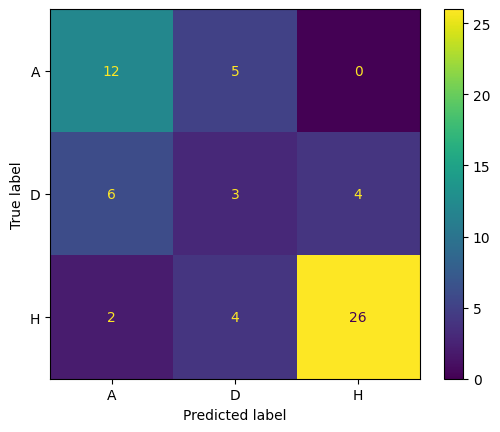

In [134]:
start = time.time()
print("Start time:", time.asctime(time.localtime(start)))

# Cross validation 
cv = 10
# evaluate model
score1 = cross_val_score(clf_rf_model, X_test, y_test, scoring='roc_auc_ovr', cv=cv, n_jobs=-1,error_score='raise')
score2 = cross_val_score(clf_rf_model, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
score3 = cross_val_score(clf_rf_model, X_test, y_test, scoring='f1_macro', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(score1))
print('Mean Accuracy score: %.3f' % np.mean(score2))
print('Mean F1 score: %.3f \n' % np.mean(score3))
# Classification report 
y_test_prd = clf_rf_model.predict(X_test)
print(classification_report(y_test, y_test_prd))
end = time.time()
print(f'Time in running training model: {round((end-start)/60,2)} min\n\n')

# Visual confusion matrix
class_ =clf_rf_model.steps[-1][1].classes_
cm = confusion_matrix(y_true=y_test,y_pred=y_test_prd)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_).plot()
plt.show()

### Gradient Boosting

In [135]:
clf_gb_model = Pipeline(steps=[
     ('preprocessor', choose_features),
    ('oversampling', SMOTE(random_state=42)),
    ('clf',GradientBoostingClassifier(random_state=42))
])
clf_gb_model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('rb_scaler',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['rank_diff']),
                                                 ('other_features',
                                                  'passthrough',
                                                  ['home_perf_wm',
                                                   'away_perf_wm',
                                                   'Home_streak_score',
                                                   'Away_streak_score',
                                                   'Home_diff_score',
                                                   'Away_diff_score'])])),
                ('oversampling', SMOTE(random_state=42)),
                ('clf', GradientBoostingClassifier(random_state=42))])

#### Evaluate data

Start time: Mon Aug 28 11:42:43 2023
Mean ROC AUC: 0.717
Mean Accuracy score: 0.583
Mean F1 score: 0.482 

              precision    recall  f1-score   support

           A       0.61      0.65      0.63        17
           D       0.20      0.15      0.17        13
           H       0.76      0.81      0.79        32

    accuracy                           0.63        62
   macro avg       0.53      0.54      0.53        62
weighted avg       0.60      0.63      0.62        62

Time in running training model: 0.07 min




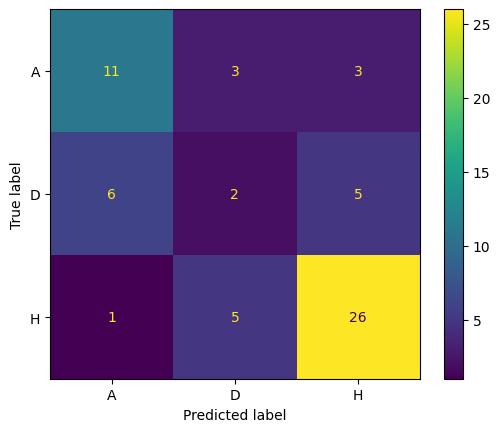

In [136]:
start = time.time()
print("Start time:", time.asctime(time.localtime(start)))
# Cross validation 
cv = 10
# evaluate model
score1 = cross_val_score(clf_gb_model, X_test, y_test, scoring='roc_auc_ovr', cv=cv, n_jobs=-1,error_score='raise')
score2 = cross_val_score(clf_gb_model, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
score3 = cross_val_score(clf_gb_model, X_test, y_test, scoring='f1_macro', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(score1))
print('Mean Accuracy score: %.3f' % np.mean(score2))
print('Mean F1 score: %.3f \n' % np.mean(score3))
# Classification report 
y_test_prd = clf_gb_model.predict(X_test)
print(classification_report(y_test, y_test_prd))
end = time.time()
print(f'Time in running training model: {round((end-start)/60,2)} min\n\n')

# Visual confusion matrix
cm = confusion_matrix(y_true=y_test,y_pred=y_test_prd)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_).plot()
plt.show()

### Ada Boosting

In [137]:
base_learner = RandomForestClassifier(random_state=42,
                                   n_jobs=-1,
                                   class_weight='balanced',
                                   max_depth=5,
                                   n_estimators=150)

In [142]:
# Build Ada boost model
clf_adb_model = Pipeline(steps=[
    ('preprocessor', choose_features),
    ('oversampling', SMOTE(random_state=42)),
    ('clf', AdaBoostClassifier(estimator=base_learner,random_state=42,algorithm='SAMME.R'))
])

# Fit model 
clf_adb_model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('rb_scaler',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['rank_diff']),
                                                 ('other_features',
                                                  'passthrough',
                                                  ['home_perf_wm',
                                                   'away_perf_wm',
                                                   'Home_streak_score',
                                                   'Away_streak_score',
                                                   'Home_diff_score',
                                                   'Away_diff_score'])])),
                ('oversampling', SMOTE(random_state=42)),
                ('clf',
                 AdaBoostClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                                     max_depth=5,
                                                                     n_estimators=150,
                                                                     n_jobs=-1,
                                                                     random_state=42),
                                    random_state=42))])

#### Evaluate

Start time: Mon Aug 28 11:45:57 2023
Mean ROC AUC: 0.722
Mean Accuracy score: 0.564
Mean F1 score: 0.451 

              precision    recall  f1-score   support

           A       0.53      0.53      0.53        17
           D       0.22      0.15      0.18        13
           H       0.75      0.84      0.79        32

    accuracy                           0.61        62
   macro avg       0.50      0.51      0.50        62
weighted avg       0.58      0.61      0.59        62

Time in running training model: 0.11 min




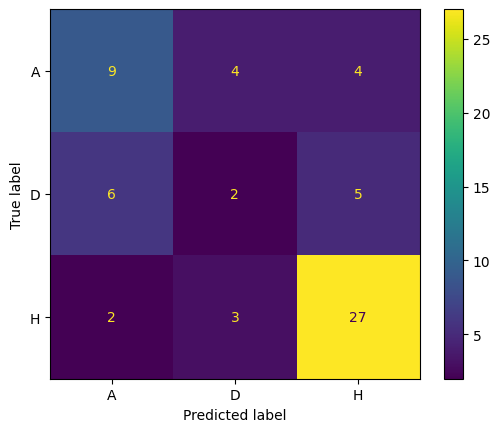

In [143]:
# Set timer
start = time.time()
print("Start time:", time.asctime(time.localtime(start)))
# Cross validation 
cv = 10
# evaluate model
score1 = cross_val_score(clf_adb_model, X_test, y_test, scoring='roc_auc_ovr', cv=cv, n_jobs=-1,error_score='raise')
score2 = cross_val_score(clf_adb_model, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
score3 = cross_val_score(clf_adb_model, X_test, y_test, scoring='f1_macro', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(score1))
print('Mean Accuracy score: %.3f' % np.mean(score2))
print('Mean F1 score: %.3f \n' % np.mean(score3))
# Classification report 
y_test_prd = clf_adb_model.predict(X_test)
print(classification_report(y_test, y_test_prd))
end = time.time()
print(f'Time in running training model: {round((end-start)/60,2)} min\n\n')

# Visual confusion matrix
cm = confusion_matrix(y_true=y_test,y_pred=y_test_prd)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_).plot()
plt.show()

# Params Tuning

In [144]:
target = 'result'
# 'home_perf_wm','away_perf_wm',
features = ['home_perf_wm', 'away_perf_wm', 'rank_diff','Home_streak_score','Away_streak_score','Home_diff_score','Away_diff_score']
wc_23_filter = (final_df['league_id']==12)&(final_df['year_league_id']==3)

# Train data
train = final_df[~wc_23_filter].sample(frac=1).reset_index(drop=True)
X_train = train[features]
y_train = train[target]

# Test data
X_test =  final_df[wc_23_filter][features]
y_test = final_df[wc_23_filter][target]

## Preprocessor

In [145]:
rb_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean', missing_values=np.nan)),
    ('scaler', RobustScaler())
])

mm_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean', missing_values=np.nan)),
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num_mm_features', mm_transformer, ['home_perf_wm','away_perf_wm','rank_diff','Home_streak_score', 'Away_streak_score', 'Home_diff_score', 'Away_diff_score'])
    ],
    remainder='drop',
    n_jobs=-1
)
preprocessor

ColumnTransformer(n_jobs=-1,
                  transformers=[('num_mm_features',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['home_perf_wm', 'away_perf_wm', 'rank_diff',
                                  'Home_streak_score', 'Away_streak_score',
                                  'Home_diff_score', 'Away_diff_score'])])

## Random Forest

In [146]:
train.describe()

,Date,year_league_id,league_id,round_id,rank_diff,home_perf_wm,away_perf_wm,Home_streak_score,Away_streak_score,Home_diff_score,Away_diff_score
count,1068,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000
mean,2022-02-14 09:31:41.123595520,1.473783,4.859551,0.478464,19.143633,0.464806,0.432723,0.051123,-0.030129,0.254801,0.127816
min,2019-06-22 00:00:00,0.000000,0.000000,0.000000,-431.890000,0.000000,0.000000,-2.008513,-2.386173,-8.125161,-7.330934
25%,2021-09-17 00:00:00,1.000000,1.000000,0.000000,-66.247500,0.284987,0.258551,-0.547719,-0.646418,-0.844932,-0.998270
50%,2022-03-27 00:00:00,1.000000,4.000000,0.000000,19.910000,0.470829,0.435969,0.088431,-0.067532,0.324743,0.233080
75%,2022-09-06 00:00:00,2.000000,10.000000,0.000000,106.767500,0.640399,0.600020,0.695290,0.610495,1.546553,1.378653
max,2023-07-21 00:00:00,3.000000,12.000000,6.000000,374.380000,1.000000,1.000000,2.210101,1.651626,6.796277,7.084087
std,NaN,0.916508,3.993778,1.032056,132.284054,0.236404,0.227258,0.702975,0.695122,2.214617,2.162754


In [147]:
choose_features = ColumnTransformer(
    transformers=[
        ('rb_scaler',rb_transformer,['rank_diff']),
        ('other_features', 'passthrough', ['home_perf_wm','away_perf_wm','Home_streak_score', 'Away_streak_score', 'Home_diff_score', 'Away_diff_score'])
    ],
    remainder='drop',
    n_jobs=-1
)

In [148]:
set_config(display="diagram")
clf_rf_model = Pipeline(steps=[
    ('features', choose_features),
    ('oversampling', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42,n_jobs=-1))
])
clf_rf_model.fit(X_train,y_train)

Pipeline(steps=[('features',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('rb_scaler',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['rank_diff']),
                                                 ('other_features',
                                                  'passthrough',
                                                  ['home_perf_wm',
                                                   'away_perf_wm',
                                                   'Home_streak_score',
                                                   'Away_streak_score',
                                                   'Home_diff_score',
                                                   'Away_diff_score'])])),
                ('oversampling', SMOTE(random_state=42)),
                ('clf', RandomForestClassifier(n_jobs=-1, random_state=42))])

## Decision Tree

In [149]:
clf_dt_model = Pipeline(steps=[
    ('features', choose_features),
    ('oversampling', SMOTE(random_state=42)),
    ('clf', DecisionTreeClassifier(random_state=42))
])
clf_dt_model.fit(X_train,y_train)

Pipeline(steps=[('features',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('rb_scaler',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['rank_diff']),
                                                 ('other_features',
                                                  'passthrough',
                                                  ['home_perf_wm',
                                                   'away_perf_wm',
                                                   'Home_streak_score',
                                                   'Away_streak_score',
                                                   'Home_diff_score',
                                                   'Away_diff_score'])])),
                ('oversampling', SMOTE(random_state=42)),
                ('clf', DecisionTreeClassifier(random_state=42))])

## KNN

In [150]:
set_config(display="diagram")
clf_knn_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('oversampling', SMOTE(random_state=42)),
    ('clf',KNeighborsClassifier(n_jobs=-1))
])
clf_knn_model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_mm_features',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['home_perf_wm',
                                                   'away_perf_wm', 'rank_diff',
                                                   'Home_streak_score',
                                                   'Away_streak_score',
                                                   'Home_diff_score',
                                                   'Away_diff_score'])])),
                ('oversampling', SMOTE(random_state=42)),
                ('clf', KNeighborsClassifier(n_jobs=-1))])

## Gaussian Naive Bayes

In [151]:
set_config(display="diagram")
clf_gnb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('oversampling', SMOTE(random_state=42)),
    ('clf',GaussianNB())
])
clf_gnb_model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_mm_features',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['home_perf_wm',
                                                   'away_perf_wm', 'rank_diff',
                                                   'Home_streak_score',
                                                   'Away_streak_score',
                                                   'Home_diff_score',
                                                   'Away_diff_score'])])),
                ('oversampling', SMOTE(random_state=42)),
                ('clf', GaussianNB())])

## Complement NB

In [152]:
set_config(display="diagram")
clf_cnb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('oversampling', SMOTE(random_state=42)),
    ('clf',ComplementNB())
])
clf_cnb_model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_mm_features',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['home_perf_wm',
                                                   'away_perf_wm', 'rank_diff',
                                                   'Home_streak_score',
                                                   'Away_streak_score',
                                                   'Home_diff_score',
                                                   'Away_diff_score'])])),
                ('oversampling', SMOTE(random_state=42)),
                ('clf', ComplementNB())])

## Gradient Boosting

In [271]:
# set_config(display="diagram")
# clf_gb_model = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('oversampling', SMOTE(random_state=42)),
#     ('clf',GradientBoostingClassifier(random_state=42))
# ])
# clf_gb_model.fit(X_train,y_train)

In [272]:
# clf_gb_model
# 'GDB':{'clf__loss': ['log_loss'],
#       'clf__n_estimators': [100,150,200],
#       'clf__max_depth': [5, 10,15],
#        'clf__min_samples_split':[2,4,6]
#       },

## Set Params

In [153]:
models = {
    'DT':clf_dt_model,
    'RF': clf_rf_model,
    'KNN': clf_knn_model,
    'GNB': clf_gnb_model,
    'CNB':clf_cnb_model
}
params = { 
    'DT': {'clf__class_weight': ['balanced'],
             'clf__splitter':['best'],
             'clf__criterion':['gini','entropy','log_loss'],
             'clf__max_depth': [5,10,15]
          },
    
    'RF': {'clf__n_estimators': [100,150,200],
           'clf__criterion':['gini','entropy','log_loss'],
           'clf__max_depth': [5, 10,15],
           'clf__class_weight': ['balanced', 'balanced_subsample'],
           'clf__min_samples_leaf':[2,3,4,6]
          },
    
    'KNN': {'clf__n_neighbors':[2,3,5,7,10],
             'clf__weights':['uniform', 'distance'],
             },
    
    'GNB': {'clf__var_smoothing':np.logspace(0,-9, num=20),
             },
    
    'CNB':{'clf__alpha': np.logspace(-6, 6, 13),
           'clf__force_alpha':[True,False],
             },
    
 }

- Use GridSearch to choose the best model with 10 times cross-validation

In [154]:
start = time.time()
print("Start time:", time.asctime(time.localtime(start)))
search = HyperclassifierSearch(models, params)
grid_search_model = search.train_model(X_train, 
                                y_train, 
                                cv=10,
                                scoring='f1_macro',
                                return_train_score=False,
                                n_jobs=-1
                               )
end = time.time()
print(f'Time in running training model: {round((end-start)/60,2)} min')

Start time: Mon Aug 28 11:50:11 2023
Search for DT ...
Search for RF ...
Search for KNN ...
Search for GNB ...
Search for CNB ...
Search is done.
Time in running training model: 11.06 min


In [155]:
df_score = search.evaluate_model(sort_by='mean_test_score', show_timing_info=True).sort_values(by=['mean_test_score','rank_test_score'],ascending=[False,True])
df_score.head(10)

,Estimator,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,RF,2.471577,0.324607,0.464900,0.237504,"{'clf__class_weight': 'balanced_subsample', 'c...",0.674532,0.712850,0.749310,0.613932,0.670639,0.654340,0.615425,0.622960,0.620399,0.608158,0.654254,0.045313,1
1,RF,2.316381,0.346162,0.457100,0.420701,"{'clf__class_weight': 'balanced_subsample', 'c...",0.674532,0.712850,0.749310,0.613932,0.670639,0.654340,0.615425,0.622960,0.620399,0.608158,0.654254,0.045313,1
2,RF,1.582199,0.307957,0.345501,0.329092,"{'clf__class_weight': 'balanced', 'clf__criter...",0.668404,0.720795,0.758502,0.610251,0.645068,0.652277,0.621212,0.623254,0.638783,0.590237,0.652878,0.048879,3
3,RF,2.147199,0.240768,0.396500,0.331799,"{'clf__class_weight': 'balanced_subsample', 'c...",0.686974,0.723345,0.733665,0.628282,0.624274,0.661251,0.615664,0.622336,0.638712,0.590237,0.652474,0.045375,4
4,RF,1.137099,0.261942,0.496800,0.282585,"{'clf__class_weight': 'balanced', 'clf__criter...",0.676193,0.720795,0.748361,0.625995,0.647473,0.646629,0.612674,0.616921,0.638783,0.590237,0.652406,0.047004,5
5,RF,1.674498,0.177073,0.416001,0.177192,"{'clf__class_weight': 'balanced', 'clf__criter...",0.679477,0.739075,0.725059,0.593136,0.654212,0.652277,0.622025,0.603228,0.638712,0.608158,0.651536,0.047454,6
6,RF,1.758398,0.323447,0.584402,0.387400,"{'clf__class_weight': 'balanced', 'clf__criter...",0.668875,0.720795,0.731595,0.635571,0.654212,0.661251,0.624569,0.608824,0.620694,0.577934,0.650432,0.045575,7
7,RF,1.913999,0.288928,0.377700,0.197289,"{'clf__class_weight': 'balanced', 'clf__criter...",0.668875,0.720795,0.731595,0.635571,0.654212,0.661251,0.624569,0.608824,0.620694,0.577934,0.650432,0.045575,7
8,RF,1.462999,0.284474,0.344009,0.247923,"{'clf__class_weight': 'balanced', 'clf__criter...",0.687709,0.739075,0.731595,0.607246,0.654212,0.654461,0.606324,0.590183,0.620694,0.608158,0.649966,0.050966,9
9,RF,1.432899,0.136940,0.386200,0.187748,"{'clf__class_weight': 'balanced', 'clf__criter...",0.687709,0.739075,0.731595,0.607246,0.654212,0.654461,0.606324,0.590183,0.620694,0.608158,0.649966,0.050966,9


In [276]:
#df_score[df_score['Estimator'].isin(['GNB','CNB'])]

In [156]:
df_score['label'] = df_score['Estimator'].astype(str) + df_score['params'].astype(str)
std = (df_score['std_test_score'].head(10)*100).to_list()
mean_ = (df_score['mean_test_score'].head(10)*100).to_list()
y_ = df_score['label'].head(10).to_list()

- Show the result after tuning:

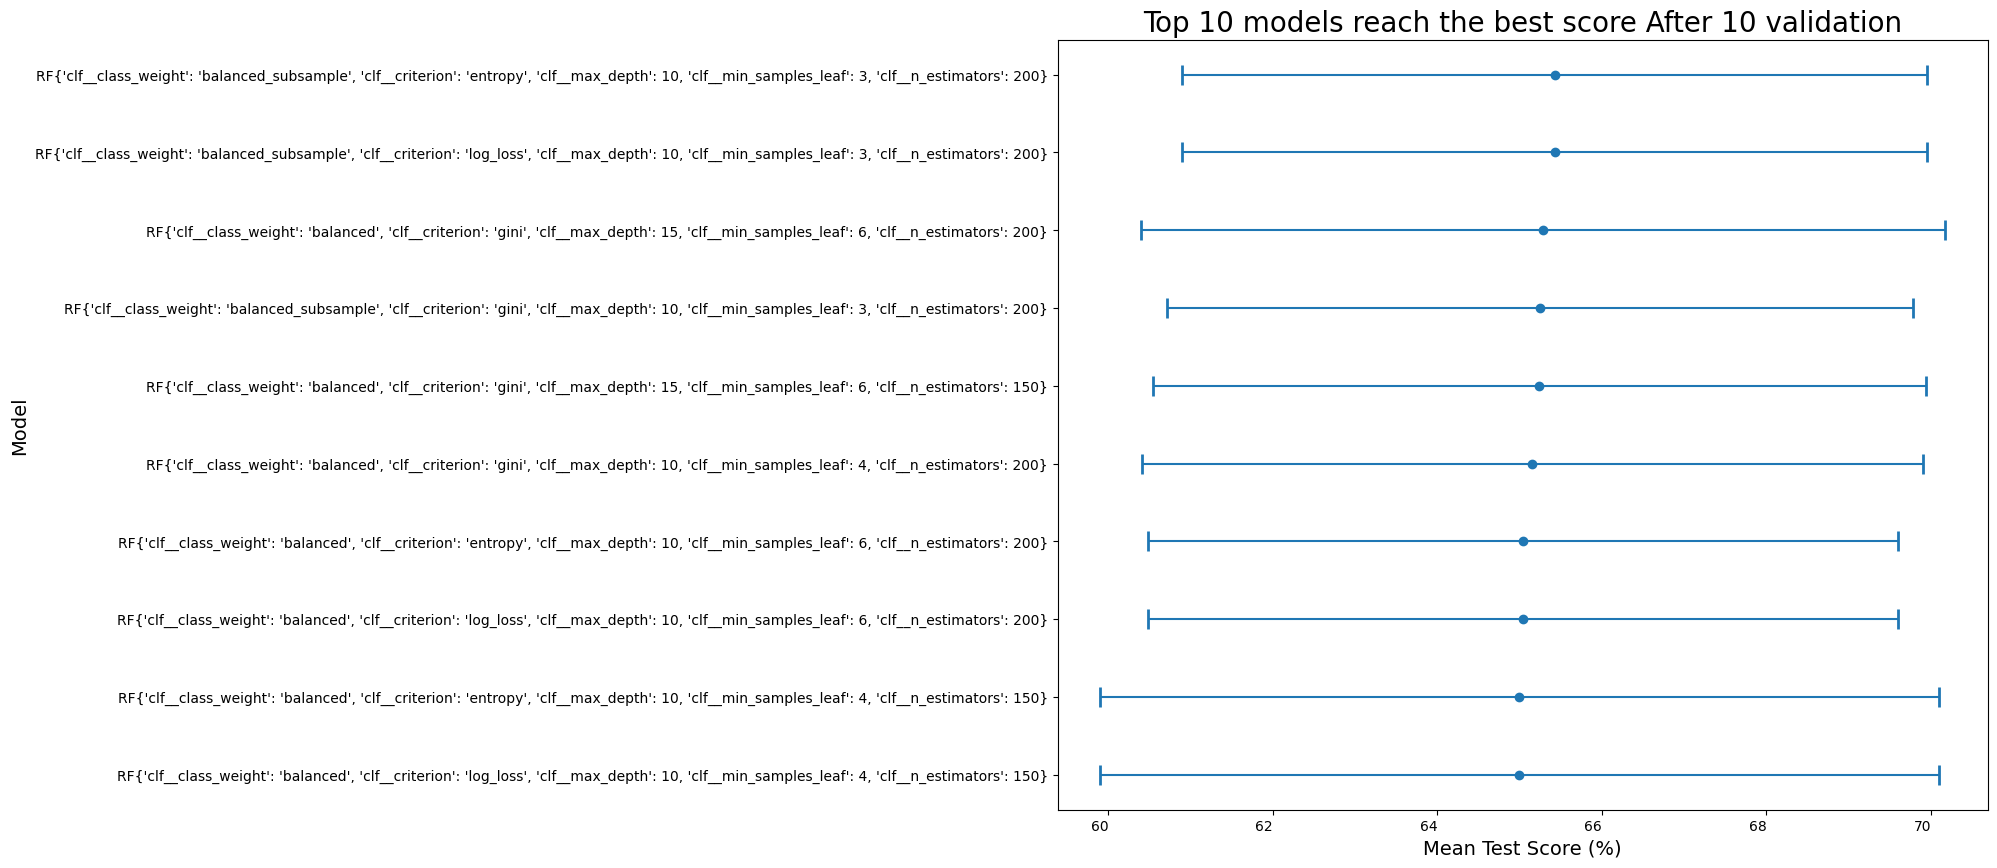

In [157]:
plt.figure(figsize=(12,10))
plt.errorbar(y=y_[::-1], 
             x=mean_[::-1], 
             xerr=std[::-1], 
             linestyle='None', 
             marker='o',
             capsize=7,
             capthick=2)

plt.xticks(ha='right')
plt.xlabel('Mean Test Score (%)',size=14)
plt.ylabel('Model',size=14)
plt.title('Top 10 models reach the best score After 10 validation',size=20,weight=2)
plt.show()

In [158]:
# Best params of Grid search model
grid_search_model.best_params_

{'clf__class_weight': 'balanced_subsample',
 'clf__criterion': 'entropy',
 'clf__max_depth': 10,
 'clf__min_samples_leaf': 3,
 'clf__n_estimators': 200}

In [165]:
df_score['params'].head(10).to_numpy()

array([{'clf__class_weight': 'balanced_subsample', 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_leaf': 3, 'clf__n_estimators': 200},
       {'clf__class_weight': 'balanced_subsample', 'clf__criterion': 'log_loss', 'clf__max_depth': 10, 'clf__min_samples_leaf': 3, 'clf__n_estimators': 200},
       {'clf__class_weight': 'balanced', 'clf__criterion': 'gini', 'clf__max_depth': 15, 'clf__min_samples_leaf': 6, 'clf__n_estimators': 200},
       {'clf__class_weight': 'balanced_subsample', 'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__min_samples_leaf': 3, 'clf__n_estimators': 200},
       {'clf__class_weight': 'balanced', 'clf__criterion': 'gini', 'clf__max_depth': 15, 'clf__min_samples_leaf': 6, 'clf__n_estimators': 150},
       {'clf__class_weight': 'balanced', 'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__min_samples_leaf': 4, 'clf__n_estimators': 200},
       {'clf__class_weight': 'balanced', 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__m

In [163]:
grid_search_model.estimator

Pipeline(steps=[('features',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('rb_scaler',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['rank_diff']),
                                                 ('other_features',
                                                  'passthrough',
                                                  ['home_perf_wm',
                                                   'away_perf_wm',
                                                   'Home_streak_score',
                                                   'Away_streak_score',
                                                   'Home_diff_score',
                                                   'Away_diff_score'])])),
                ('oversampling', SMOTE(random_state=42)),
                ('clf', RandomForestClassifier(n_jobs=-1, random_state=42))])

In [183]:
choose_features = ColumnTransformer(
    transformers=[
        ('features', 'passthrough', ['home_perf_wm','away_perf_wm','rank_diff','Home_streak_score', 'Away_streak_score', 'Home_diff_score', 'Away_diff_score'])
    ],
    remainder='drop',
    n_jobs=-1
)

final_rf_model = Pipeline(steps=[
    ('features', choose_features),
    ('oversampling', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42,
                                   n_jobs=-1,
                                   class_weight='balanced_subsample',
                                   max_depth=10,
                                   criterion='entropy',
                                   min_samples_leaf=3, 
                                   n_estimators=200))
])
final_rf_model.fit(X_train,y_train)

Pipeline(steps=[('features',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('features', 'passthrough',
                                                  ['home_perf_wm',
                                                   'away_perf_wm', 'rank_diff',
                                                   'Home_streak_score',
                                                   'Away_streak_score',
                                                   'Home_diff_score',
                                                   'Away_diff_score'])])),
                ('oversampling', SMOTE(random_state=42)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        criterion='entropy', max_depth=10,
                                        min_samples_leaf=3, n_estimators=200,
                                        n_jobs=-1, random_state=42))])

In [184]:
# Build Ada boost model
base =  RandomForestClassifier(random_state=42,
                                   n_jobs=-1,
                                   class_weight='balanced_subsample',
                                   max_depth=10,
                                   criterion='entropy',
                                   min_samples_leaf=3, 
                                   n_estimators=200)
clf_adb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('oversampling', SMOTE(random_state=42)),
    ('clf', AdaBoostClassifier(estimator=base,random_state=42,algorithm='SAMME.R'))
])

# Fit model 
clf_adb_model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_mm_features',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['home_perf_wm',
                                                   'away_perf_wm', 'rank_diff',
                                                   'Home_streak_score',
                                                   'Away_streak_score',
                                                   'Home_diff_score',
                                                   'Away_diff_score'])])),
                ('oversampling', SMOTE(random_state=42)),
                ('clf',
                 AdaBoostClassifier(estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                                     criterion='entropy',
                                                                     max_depth=10,
                                                                     min_samples_leaf=3,
                                                                     n_estimators=200,
                                                                     n_jobs=-1,
                                                                     random_state=42),
                                    random_state=42))])

## Evaluate Params

Start time: Mon Aug 28 12:07:39 2023
Mean ROC AUC: 0.819
Mean Accuracy score: 0.548
Mean F1 score: 0.404 

              precision    recall  f1-score   support

           A       0.57      0.71      0.63        17
           D       0.29      0.15      0.20        13
           H       0.79      0.84      0.82        32

    accuracy                           0.66        62
   macro avg       0.55      0.57      0.55        62
weighted avg       0.63      0.66      0.64        62

Time in running training model: 0.13 min




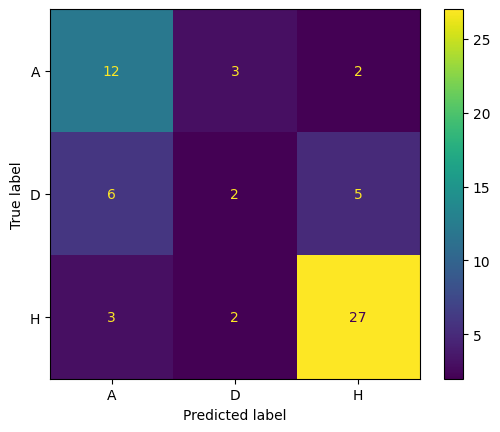

In [171]:
class_ = final_rf_model.classes_
# Set timer
start = time.time()
print("Start time:", time.asctime(time.localtime(start)))
# Cross validation 
cv = 10
# evaluate model
score1 = cross_val_score(final_rf_model, X_test, y_test, scoring='roc_auc_ovr', cv=cv, n_jobs=-1,error_score='raise')
print('Mean ROC AUC: %.3f' % np.mean(score1))

score2 = cross_val_score(final_rf_model, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy score: %.3f' % np.mean(score2))

score3 = cross_val_score(final_rf_model, X_test, y_test, scoring='f1_macro', cv=cv, n_jobs=-1)
print('Mean F1 score: %.3f \n' % np.mean(score3))



# Classification report 
y_test_prd = final_rf_model.predict(X_test)
print(classification_report(y_test, y_test_prd))
end = time.time()
print(f'Time in running training model: {round((end-start)/60,2)} min\n\n')

# Visual confusion matrix
cm = confusion_matrix(y_true=y_test,y_pred=y_test_prd)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_).plot()
plt.show()

Start time: Mon Aug 21 17:13:28 2023
Mean ROC AUC: 0.740
Mean Accuracy score: 0.564
Mean F1 score: 0.439 

              precision    recall  f1-score   support

           A       0.50      0.59      0.54        17
           D       0.30      0.23      0.26        13
           H       0.69      0.69      0.69        32

    accuracy                           0.56        62
   macro avg       0.50      0.50      0.50        62
weighted avg       0.55      0.56      0.56        62

Time in running training model: 0.11 min




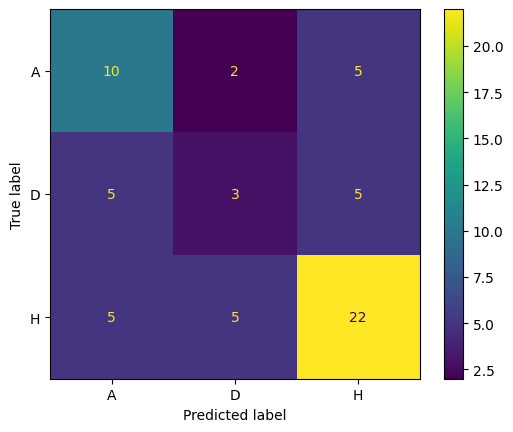

In [429]:
# class_ = final_rf_model.classes_
# # Set timer
# start = time.time()
# print("Start time:", time.asctime(time.localtime(start)))
# # Cross validation 
# cv = 10
# # evaluate model
# score1 = cross_val_score(final_rf_model, X_test, y_test, scoring='roc_auc_ovr', cv=cv, n_jobs=-1,error_score='raise')
# print('Mean ROC AUC: %.3f' % np.mean(score1))

# score2 = cross_val_score(final_rf_model, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
# print('Mean Accuracy score: %.3f' % np.mean(score2))

# score3 = cross_val_score(final_rf_model, X_test, y_test, scoring='f1_macro', cv=cv, n_jobs=-1)
# print('Mean F1 score: %.3f \n' % np.mean(score3))



# # Classification report 
# y_test_prd = final_rf_model.predict(X_test)
# print(classification_report(y_test, y_test_prd))
# end = time.time()
# print(f'Time in running training model: {round((end-start)/60,2)} min\n\n')

# # Visual confusion matrix
# cm = confusion_matrix(y_true=y_test,y_pred=y_test_prd)
# ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_).plot()
# plt.show()

## Evaluate the ADA boost

Start time: Mon Aug 28 12:12:09 2023
Mean ROC AUC: 0.810
Mean Accuracy score: 0.598
Mean F1 score: 0.491 

              precision    recall  f1-score   support

           A       0.60      0.71      0.65        17
           D       0.14      0.08      0.10        13
           H       0.77      0.84      0.81        32

    accuracy                           0.65        62
   macro avg       0.50      0.54      0.52        62
weighted avg       0.59      0.65      0.61        62

Time in running training model: 0.16 min




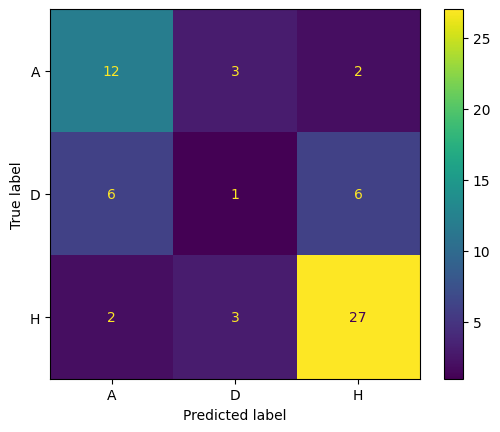

In [173]:
class_ = clf_adb_model.classes_
# Set timer
start = time.time()
print("Start time:", time.asctime(time.localtime(start)))
# Cross validation 
cv = 10
# evaluate model
score1 = cross_val_score(clf_adb_model, X_test, y_test, scoring='roc_auc_ovr', cv=cv, n_jobs=-1,error_score='raise')
print('Mean ROC AUC: %.3f' % np.mean(score1))

score2 = cross_val_score(clf_adb_model, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy score: %.3f' % np.mean(score2))

score3 = cross_val_score(clf_adb_model, X_test, y_test, scoring='f1_macro', cv=cv, n_jobs=-1)
print('Mean F1 score: %.3f \n' % np.mean(score3))



# Classification report 
y_test_prd = clf_adb_model.predict(X_test)
print(classification_report(y_test, y_test_prd))
end = time.time()
print(f'Time in running training model: {round((end-start)/60,2)} min\n\n')

# Visual confusion matrix
cm = confusion_matrix(y_true=y_test,y_pred=y_test_prd)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_).plot()
plt.show()

## Evaluate the ADA boost final

In [181]:
# filename = 'final_rf_model.pkl'
# with open(filename, 'rb') as file:
#     final_rf_model = pickle.load(file)

In [182]:
# class_ = ada_proba_model.classes_
# # Set timer
# start = time.time()
# print("Start time:", time.asctime(time.localtime(start)))
# # Cross validation 
# cv = 10
# # evaluate model
# score1 = cross_val_score(clf_adb_model, X_test, y_test, scoring='roc_auc_ovr', cv=cv, n_jobs=-1,error_score='raise')
# print('Mean ROC AUC: %.3f' % np.mean(score1))

# score2 = cross_val_score(clf_adb_model, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
# print('Mean Accuracy score: %.3f' % np.mean(score2))

# score3 = cross_val_score(clf_adb_model, X_test, y_test, scoring='f1_macro', cv=cv, n_jobs=-1)
# print('Mean F1 score: %.3f \n' % np.mean(score3))

# # Classification report 
# y_test_prd = final_rf_model.predict(X_test)
# print(classification_report(y_test, y_test_prd))
# end = time.time()
# print(f'Time in running training model: {round((end-start)/60,2)} min\n\n')

# # Visual confusion matrix
# cm = confusion_matrix(y_true=y_test,y_pred=y_test_prd)
# ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_).plot()
# plt.show()

# Create Dataset WC23

- Create pickle file

In [187]:
# filename = 'final_rf_model.pkl'
# with open(filename, 'wb') as file:
#     pickle.dump(final_rf_model, file)

- Load pickle file

# Outright final winner

In [22]:
filename = 'final_rf_model.pkl'
with open(filename, 'rb') as file:
    final_rf_model = pickle.load(file)
final_rf_model

Pipeline(steps=[('features',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('features', 'passthrough',
                                                  ['home_perf_wm',
                                                   'away_perf_wm', 'rank_diff',
                                                   'Home_streak_score',
                                                   'Away_streak_score',
                                                   'Home_diff_score',
                                                   'Away_diff_score'])])),
                ('oversampling', SMOTE(random_state=42)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        criterion='entropy', max_depth=10,
                                        min_samples_leaf=3, n_estimators=200,
                                        n_jobs=-1, random_state=42))])

## Creat data WC23

In [23]:
target = 'result'

features = ['home_perf_wm','away_perf_wm','rank_diff','Home_streak_score','Away_streak_score','Home_diff_score','Away_diff_score']
wc_23_filter = (final_df['league_id']==12)&(final_df['year_league_id']==3)

# Train data
train = final_df[~wc_23_filter].sample(frac=1,random_state=1).reset_index(drop=True)
X_train = train[features]
y_train = train[target]

In [24]:
#final_rf_model.fit(X_train,y_train)

In [25]:
wc_23 = final_df[wc_23_filter]

# Add result to wc23
prob_name = ['prob_'+a for a in final_rf_model.classes_]
wc_23.loc[:,'prediction'] = final_rf_model.predict(wc_23)
wc_23.loc[:,prob_name] = final_rf_model.predict_proba(wc_23)

# Get some specific feature
col = ['Date','year_league_id','league_id', 'round_id', 'Home', 'Away', 'home_perf_wm',
       'away_perf_wm', 'rank_diff', 'Home_streak_score', 'Away_streak_score',
       'Home_diff_score', 'Away_diff_score', 'result', 'pen_result',
       'prediction', 'prob_A', 'prob_D', 'prob_H']
wc_23 = wc_23[col]
wc_23.head()

,Date,year_league_id,league_id,round_id,Home,Away,home_perf_wm,away_perf_wm,rank_diff,Home_streak_score,Away_streak_score,Home_diff_score,Away_diff_score,result,pen_result,prediction,prob_A,prob_D,prob_H
1068,2023-07-20,3,12,0,New Zealand,Norway,0.280633,0.498460,-138.92,-0.525744,-1.123706,-0.564239,-0.749513,H,0,A,0.678898,0.127485,0.193617
1069,2023-07-20,3,12,0,Australia,Rep. of Ireland,0.477616,0.400919,66.94,2.565612,-0.458998,1.771628,0.187861,H,0,H,0.265363,0.335603,0.399034
1070,2023-07-21,3,12,0,Nigeria,Canada,0.413528,0.592926,-137.90,-0.724419,-0.849382,-0.129664,-0.658160,D,0,A,0.665542,0.130164,0.204293
1071,2023-07-21,3,12,0,Philippines,Switzerland,0.469369,0.318829,-109.55,-1.019721,-0.395128,-0.441284,-0.148625,A,0,A,0.573585,0.296255,0.130160
1072,2023-07-21,3,12,0,Spain,Costa Rica,0.854754,0.366998,300.43,1.000000,-0.901858,3.176385,-1.258867,H,0,H,0.008294,0.019999,0.971707


In [26]:
#1/wc_23[['prob_A','prob_D','prob_H']]

In [27]:
(wc_23['result'] == wc_23['prediction']).value_counts(normalize=True)

True     0.66129
False    0.33871
Name: proportion, dtype: float64

In [28]:
wc_23.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62 entries, 1068 to 1129
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               62 non-null     datetime64[ns]
 1   year_league_id     62 non-null     int64         
 2   league_id          62 non-null     int64         
 3   round_id           62 non-null     int64         
 4   Home               62 non-null     object        
 5   Away               62 non-null     object        
 6   home_perf_wm       62 non-null     float64       
 7   away_perf_wm       62 non-null     float64       
 8   rank_diff          62 non-null     float64       
 9   Home_streak_score  62 non-null     float64       
 10  Away_streak_score  62 non-null     float64       
 11  Home_diff_score    62 non-null     float64       
 12  Away_diff_score    62 non-null     float64       
 13  result             62 non-null     object        
 14  pen_result  

## Get the winner and start the new round

## Define Function

In [29]:
virtual_result_dfs = list()
def predict_winner(model,
                   virtual_match_data: list,
                   actual_df,
                   feat_eng_pipeline=feat_eng_pipe,
                   ):
    # Recalculate probability
    def probability_in_2_ouputs(pro_h, pro_a):
        result = pro_h / (pro_h + pro_a)
        return result

    if type(virtual_match_data) == list:
        # Prepare data in case virtual_match_data is dict
        virtual_match_df = pd.DataFrame(virtual_match_data)
        virtual_match_df['Group_id'] = np.where(virtual_match_df.index < 4, 1, 2).astype(np.int64)
        virtual_match_df['Match_id'] = virtual_match_df.groupby('Group_id', as_index=False).cumcount()
    else:
        virtual_match_df = virtual_match_data

    # Check date of match if match occurred, merge with final data, else get the current date
    round_id = virtual_match_df['round_id'].unique()[0]
    league_id = virtual_match_df['league_id'].unique()[0]
    year_league_id = virtual_match_df['year_league_id'].unique()[0]

    # Check this is the real data or virtual data
    fil = ((actual_df['year_league_id'] == year_league_id) & (actual_df['league_id'] == league_id) & (actual_df['round_id'] == round_id))
    match_occurred = any(fil)

    ### IF MATCH OCCURRED, NOT VIRTUAL ROUND ###
    if match_occurred:
        true_df = actual_df[fil]
        virtual_match_df = pd.merge(left=virtual_match_df,
                                    right=true_df[['year_league_id','league_id', 'round_id', 'Home', 'Away', 'Date']],
                                    on=['year_league_id','league_id', 'round_id', 'Home', 'Away'], how='left')
        
        # If this tournament is playing but match is not occuring => fillna with current date
        virtual_match_df['Date'] = virtual_match_df['Date'].fillna(pd.to_datetime(datetime.now().date()))
    else:
        # the round have been occurring in the reality
        virtual_match_df['Date'] = pd.to_datetime(datetime.now().date())
        virtual_match_org = virtual_match_df.copy()

    # transform dataframe
    virtual_match_feat_df = feat_eng_pipeline.transform(virtual_match_df)
    # Get match id and group id
    virtual_match_feat_df = pd.merge(left=virtual_match_feat_df,
                                     right=virtual_match_df[['year_league_id','league_id', 'round_id', 'Home', 'Away','Group_id','Match_id']],
                                     on=['year_league_id','league_id', 'round_id', 'Home', 'Away']
                                     ,how='left')

    # Predict the match then combine to dataframe
    virtual_match_feat_df.loc[:, 'prediction'] = model.predict(virtual_match_feat_df)

    # Predict probability then combine to dataframe
    prob_name = ['prob_' + a for a in model.classes_]
    virtual_match_feat_df.loc[:, prob_name] = model.predict_proba(virtual_match_feat_df)

    if match_occurred:
        # Compare with actual match
        virtual_result_df = pd.merge(left=virtual_match_feat_df.drop(columns=['Date']),
                                     right=true_df[['round_id', 'Home', 'Away', 'result', 'pen_result', 'Date']],
                                     on=['round_id', 'Home', 'Away'],
                                     how='left').fillna({'Date':pd.to_datetime(datetime.now().date())})

        # Eliminate the probability of Draw, only using the Home prob or Away prob because this is the knock out stage
        virtual_result_df['prob_H'] = virtual_result_df['prob_H'] / (virtual_result_df['prob_H'] + virtual_result_df['prob_A'])
        virtual_result_df['prob_A'] = virtual_result_df['prob_A'] / (virtual_result_df['prob_H'] + virtual_result_df['prob_A'])
        
        virtual_result_df['prediction'] = np.where(virtual_result_df['prob_H'] > virtual_result_df['prob_A'], 'H', 'A')
        virtual_result_df = virtual_result_df.drop(columns='prob_D')

        fil = (virtual_result_df['result'] == virtual_result_df['prediction']) | (virtual_result_df['pen_result'] == virtual_result_df['prediction'])
        virtual_result_df['is_correct'] = np.where(fil, True, False)

        # Get the result
        print(f"the model predict correct {fil.sum()} on {fil.count()} matches")
        print(
            f" the wrong results are below: \n{virtual_result_df[~fil][['year_league_id','league_id', 'round_id', 'Home', 'Away', 'prob_H', 'prob_A', 'prediction', 'result', 'pen_result']]}")
        order_col = ['Date','year_league_id', 'league_id', 'round_id', 'Group_id', 'Match_id', 'Home', 'Away', 'prob_H', 'prob_A',
                     'prediction', 'result', 'pen_result', 'is_correct']
        return virtual_result_df[order_col]
        
    # If the match does not occur, the match will be double
    else:
        
        # Check if this is the double game match or not
        system_calculate = any(virtual_match_feat_df.duplicated(subset=['Group_id', 'Match_id']))
        if system_calculate:
            
            # Recalcualte the probility of Home and Away because from round 16, there is 2 likelihood occuring: Home win or Away win
            virtual_match_feat_df['prob_H_'] = virtual_match_feat_df[['prob_H', 'prob_A']].apply(lambda x: probability_in_2_ouputs(pro_h=x['prob_H'], 
                                                                                                                                   pro_a=x['prob_A']), 
                                                                                                 axis=1)
            virtual_match_feat_df['prob_A_'] = 1 - virtual_match_feat_df['prob_H_']

            # Create data frame to get which team has higher proportion to win in 2 matches
            ls_ = list()
            for i, h, a, p_h, p_a in virtual_match_feat_df[['Home', 
                                                            'Away', 
                                                            'prob_H_', 
                                                            'prob_A_']].itertuples(index=True, name=None):
                try:
                    match_dict = dict()
                    ## Check Home or Away has higher winning probability ? 
                    if h == virtual_match_feat_df.loc[i + 1, 'Away'] and a == virtual_match_feat_df.loc[i + 1, 'Home']:
                        match_dict['Home'] = h
                        match_dict['Away'] = a
                        pro_h_2 = (p_h + virtual_match_feat_df.loc[i + 1, 'prob_A_']) / 2
                        pro_a_2 = (p_a + virtual_match_feat_df.loc[i + 1, 'prob_H_']) / 2
                        match_dict['prob_H'] = pro_h_2
                        match_dict['prob_A'] = pro_a_2
                        if pro_h_2 > pro_a_2:
                            match_dict['prediction'] = 'H'
                        else:
                            match_dict['prediction'] = 'A'
                            
                        ls_.append(match_dict)
                    else:
                        pass
                except Exception as e:
                    break

            # Combine to 2 df to compatible with next function
            df_prob = pd.DataFrame(ls_)
            virtual_feat = ['Date','year_league_id', 'league_id', 'round_id', 'Group_id', 'Match_id', 'Home', 'Away']
            virtual_match_feat_df = virtual_match_feat_df.drop_duplicates(subset=['Date', 
                                                                                  'year_league_id',
                                                                                  'league_id', 
                                                                                  'round_id', 
                                                                                  'Group_id', 
                                                                                  'Match_id'])[virtual_feat]
            virtual_match_feat_df['year_league_id'] = virtual_match_org['year_league_id'].max()
            return pd.merge(left=virtual_match_feat_df,
                            right=df_prob,
                            on=['Home', 'Away'],
                            how='outer')

        else:
            # Eliminate the probability of Draw, only using the Home prob or Away prob because this is the knock out stage
            virtual_match_feat_df['prob_H'] = virtual_match_feat_df[['prob_H', 'prob_A']].apply(lambda x: probability_in_2_ouputs(pro_h=x['prob_H'], 
                                                                                                                                  pro_a=x['prob_A']),
                                                                                                axis=1)
            virtual_match_feat_df['prob_A'] = 1 - virtual_match_feat_df['prob_H']
            virtual_match_feat_df['prediction'] = np.where(virtual_match_feat_df['prob_H'] > virtual_match_feat_df['prob_A'], 'H', 'A')
            order_col = ['Date','year_league_id', 'league_id', 'round_id', 'Group_id', 'Match_id', 'Home', 'Away', 'prob_H', 'prob_A','prediction']
            virtual_match_feat_df['year_league_id'] = virtual_match_org['year_league_id'].max()
            return virtual_match_feat_df[order_col]

In [30]:
def arrange_next_round(virtual_df, run_simulate:bool= False):
    ls_winner = list()
    # check df columns contain reuslt and pen result or not?
    if 'pen_result' in virtual_df.columns and 'result' in virtual_df.columns:
        print('There is this round in historical data')
        cols = ['year_league_id', 'league_id', 'round_id', 'Group_id', 'Match_id', 'Home', 'Away', 'result', 'pen_result','prediction']
        match_df = virtual_df[cols]

        # Get Actual winner from true label
        for y_id,t_id, r_id, g_id, m_id, h, a, r, pen_r, prd in match_df.itertuples(index=False, name=None):
            dict_match = dict()
            dict_match['year_league_id'] = y_id
            dict_match['league_id'] = t_id
            dict_match['round_id'] = r_id + 1
            dict_match['Group_id'] = g_id
            if m_id % 2 == 0:
                dict_match['Match_id'] = 0
            else:
                dict_match['Match_id'] = 2
               
             # Get team winner
            if r is np.nan:
                if prd == 'A':
                    dict_match['winner_team'] = a
                else:
                    dict_match['winner_team'] = h
                    
            elif r == 'A':
                dict_match['winner_team'] = a
            elif r == 'H':
                dict_match['winner_team'] = h
            
            else:
                if pen_r == 'H':
                    dict_match['winner_team'] = h
                else:
                    dict_match['winner_team'] = a

            # add dict to list winner
            ls_winner.append(dict_match)

     # In case: This game is virtual
    else:
        print('This round still not happens in the reality >> Start to calculate...')
        cols = ['year_league_id', 'league_id', 'round_id', 'Group_id', 'Match_id', 'Home', 'Away', 'prediction', 'prob_H', 'prob_A']
        match_df = virtual_df[cols]
        # Get winner from prediction 
        for y_id, t_id, r_id, g_id, m_id, h, a, prd, pro_h, pro_a in match_df.itertuples(index=False, name=None):
            if run_simulate:
                Inconstant_range = random.randint(1,100)
            else:
                Inconstant_range = 0
            
            dict_match = dict()
            dict_match['year_league_id'] = y_id
            dict_match['league_id'] = t_id
            dict_match['round_id'] = r_id + 1
            dict_match['Group_id'] = g_id
            if m_id % 2 == 0:
                dict_match['Match_id'] = 0
            else:
                dict_match['Match_id'] = 2
                # Get team winner
            if prd == 'A':
                # Set Simulation
                if Inconstant_range < pro_a*100:
                    dict_match['winner_team'] = a
                    if run_simulate:
                        print(f"{h} vs {a}\n>>>>>> With the inconstant range as {Inconstant_range}%, because it LOWER than wininng prob ({round(pro_a*100,2)}%) of AWAY team ({a}) => keep the <{a}>\n")
                else:
                    dict_match['winner_team'] = h
                    if run_simulate:
                        print(f"{h} vs {a}\n>>>>>> With the inconstant range as {Inconstant_range}%, because it HIGHER than wininng prob ({round(pro_a*100,2)}%) of AWAY team ({a}) =>**CHANGE WINNING TEAM to {h}**\n")
            elif prd == 'H':
                # Set Simulation
                if Inconstant_range < pro_h*100:
                    dict_match['winner_team'] = h
                    if run_simulate:
                        print(f"{h} vs {a}\n>>>>>> With the inconstant range as {Inconstant_range}%, because it LOWER than wininng prob ({round(pro_h*100,2)}%) of HOME team ({h}) => keep the <{h}>\n")
                else:
                    dict_match['winner_team'] = a
                    if run_simulate:
                        print(f"{h} vs {a}\n>>>>>> With the inconstant range as {Inconstant_range}%, because it HIGHER than wininng prob ({round(pro_h*100,2)}%) of HOME team ({h}) =>**CHANGE WINNING TEAM to {a}**\n")
            # else:
            #     if pro_a > pro_h:
            #         dict_match['winner_team'] = a
            #     else:
            #         dict_match['winner_team'] = h

            # add dict to list winner
            ls_winner.append(dict_match)

    # Create next round:
    winner_group = pd.DataFrame(ls_winner)

    # In final 2 team head to head => no more group
    if winner_group.shape[0] == 2:
        winner_group['Group_id'] = 0

    winner_group = winner_group.groupby(['year_league_id', 
                                         'league_id', 
                                         'round_id', 
                                         'Group_id', 
                                         'Match_id'], as_index=False).agg({'winner_team': list})

    # create next round in 2 way 
    # First match
    next_round = pd.concat([winner_group.drop(columns='winner_team'),
                            pd.DataFrame(winner_group['winner_team'].tolist(), index=winner_group.index)],
                           axis=1).rename(columns={0: 'Home', 1: 'Away'})
    # Double match
    next_round_revese = pd.concat([winner_group.drop(columns='winner_team'),
                                   pd.DataFrame(winner_group['winner_team'].tolist(), index=winner_group.index)],
                                  axis=1).rename(columns={1: 'Home', 0: 'Away'})
    
    comb_next_round = pd.concat([next_round, next_round_revese], axis=0).sort_values(by=['year_league_id', 
                                                                                         'league_id', 
                                                                                         'round_id', 
                                                                                         'Group_id', 
                                                                                         'Match_id'])
    
    # Check date of match if match occurred, merge with final data, else get the current date
    round_id = comb_next_round['round_id'].unique()[0]
    league_id = comb_next_round['league_id'].unique()[0]
    year_league_id = comb_next_round['year_league_id'].unique()[0]

    # Check this is the real data or virtual data
    fil = ((final_df['year_league_id'] == year_league_id) & (final_df['league_id'] == league_id) & (final_df['round_id'] == round_id))
    match_occurred = any(fil)

    ### IF MATCH OCCURRED, NOT VIRTUAL ROUND ###
    if match_occurred:
        true_df = final_df[fil]
        comb_next_round = pd.merge(left=comb_next_round,
                                    right=true_df[['year_league_id','league_id', 'round_id', 'Home', 'Away']],
                                    on=['year_league_id','league_id', 'round_id', 'Home', 'Away'], how='inner')
        return comb_next_round
    else:
        return next_round.sort_values(by=['year_league_id', 
                                         'league_id', 
                                         'round_id', 
                                         'Group_id', 
                                         'Match_id'])

## Breakdown

In [199]:
final_df.head()

,Date,year_league_id,league_id,round_id,Home,Away,rank_diff,home_perf_wm,away_perf_wm,Home_streak_score,Away_streak_score,Home_diff_score,Away_diff_score,result,pen_result
0,2019-06-22,0,12,2,Germany,Nigeria,132.52,0.903734,0.250000,1.000000,-0.480727,1.830832,-0.653192,H,0
1,2019-06-22,0,12,2,Norway,Australia,-3.26,0.640884,0.500000,0.480727,0.333333,1.000000,0.922293,D,H
2,2019-06-23,0,12,2,England,Cameroon,135.68,0.714286,0.250000,1.000000,-0.480727,1.326602,-0.612768,H,0
3,2019-06-23,0,12,2,France,Brazil,94.70,0.867104,0.499975,1.000000,0.771056,2.040424,0.927896,H,0
4,2019-06-24,0,12,2,Spain,USA,-116.78,0.486975,1.000000,0.000000,1.000000,0.500000,6.121272,A,0


In [201]:
fil = (final_df['year_league_id']==3)&(final_df['league_id']==12)&(final_df['round_id']==2)
test = final_df[fil]
#test[(test['Home'].isin(['New Zealand','Norway']))&(test['Away'].isin(['New Zealand','Norway']))]
test

,Date,year_league_id,league_id,round_id,Home,Away,rank_diff,home_perf_wm,away_perf_wm,Home_streak_score,Away_streak_score,Home_diff_score,Away_diff_score,result,pen_result
1116,2023-08-05,3,12,2,Switzerland,Spain,-215.42,0.318829,0.854754,0.088662,0.845684,0.130728,1.384266,A,0
1117,2023-08-05,3,12,2,Japan,Norway,143.18,0.671801,0.498460,0.934115,-0.738726,2.643030,0.248771,H,0
1118,2023-08-06,3,12,2,Netherlands,South Africa,267.47,0.648228,0.515400,0.729044,-0.811613,1.642013,-1.559592,H,0
1119,2023-08-06,3,12,2,Sweden,USA,-30.05,0.631027,0.777648,0.458667,0.813606,0.778691,0.876875,D,H
1120,2023-08-07,3,12,2,England,Nigeria,268.15,0.773245,0.413528,0.085822,0.209506,-0.345369,0.587595,D,H
1121,2023-08-07,3,12,2,Australia,Denmark,31.33,0.477616,0.631473,2.193590,0.515515,1.064797,0.319085,H,0
1122,2023-08-08,3,12,2,Colombia,Jamaica,123.90,0.601913,0.376079,0.313205,0.294470,0.427127,0.410283,H,0
1123,2023-08-08,3,12,2,France,Morocco,231.98,0.770163,0.581919,0.201440,-0.321159,0.615458,-0.231443,H,0


In [203]:
fil = (final_df['year_league_id']==3)&(final_df['league_id']==12)&(final_df['round_id']==2)
test = final_df[fil]
col_vir_round = ['year_league_id','league_id', 'round_id', 'Group_id', 'Match_id','Home', 'Away']
virtual_match =  test[['year_league_id','league_id', 'round_id','Home', 'Away']].reset_index(drop=True)
virtual_match

,year_league_id,league_id,round_id,Home,Away
0,3,12,2,Switzerland,Spain
1,3,12,2,Japan,Norway
2,3,12,2,Netherlands,South Africa
3,3,12,2,Sweden,USA
4,3,12,2,England,Nigeria
5,3,12,2,Australia,Denmark
6,3,12,2,Colombia,Jamaica
7,3,12,2,France,Morocco


In [205]:
match_list = [{'year_league_id':3,
               'league_id':12, 
               'round_id':2,
               'Home':h,
               'Away':a} for h, a in virtual_match[['Home', 'Away']].itertuples(index=False,name=None)]
match_list

[{'year_league_id': 3,
  'league_id': 12,
  'round_id': 2,
  'Home': 'Switzerland',
  'Away': 'Spain'},
 {'year_league_id': 3,
  'league_id': 12,
  'round_id': 2,
  'Home': 'Japan',
  'Away': 'Norway'},
 {'year_league_id': 3,
  'league_id': 12,
  'round_id': 2,
  'Home': 'Netherlands',
  'Away': 'South Africa'},
 {'year_league_id': 3,
  'league_id': 12,
  'round_id': 2,
  'Home': 'Sweden',
  'Away': 'USA'},
 {'year_league_id': 3,
  'league_id': 12,
  'round_id': 2,
  'Home': 'England',
  'Away': 'Nigeria'},
 {'year_league_id': 3,
  'league_id': 12,
  'round_id': 2,
  'Home': 'Australia',
  'Away': 'Denmark'},
 {'year_league_id': 3,
  'league_id': 12,
  'round_id': 2,
  'Home': 'Colombia',
  'Away': 'Jamaica'},
 {'year_league_id': 3,
  'league_id': 12,
  'round_id': 2,
  'Home': 'France',
  'Away': 'Morocco'}]

In [237]:
match_list = [
    {'year_league_id':3,'league_id':12, 'round_id': 2, 'Home': 'Switzerland', 'Away': 'Spain'},
    {'year_league_id':3,'league_id':12, 'round_id': 2, 'Home': 'Japan', 'Away': 'Norway'},
    {'year_league_id':3,'league_id':12,'round_id': 2,'Home': 'Netherlands','Away': 'South Africa'},
    {'year_league_id':3,'league_id':12, 'round_id': 2, 'Home': 'Sweden', 'Away': 'USA'},
    {'year_league_id':3,'league_id':12, 'round_id': 2, 'Home': 'England', 'Away': 'Nigeria'},
    {'year_league_id':3,'league_id':12, 'round_id': 2, 'Home': 'Australia', 'Away': 'Denmark'},
    {'year_league_id':3,'league_id':12, 'round_id': 2, 'Home': 'Colombia', 'Away': 'Jamaica'},
    {'year_league_id':3,'league_id':12, 'round_id': 2, 'Home': 'France', 'Away': 'Morocco'}
]

virtual_match_df = pd.DataFrame(match_list)

# Check date of match if match occurred, merge with final data, else get the current date 
round_id = virtual_match_df['round_id'].unique()[0]
league_id = virtual_match_df['league_id'].unique()[0]
match_occurred = any((final_df['league_id']==league_id)&(final_df['round_id']==round_id))
if match_occurred:
    virtual_match_df = pd.merge(left=virtual_match_df,
                                right=final_df[['league_id','round_id','Home','Away','Date']],
                                on=['league_id','round_id','Home','Away'],how='left')
    
    # If this round is playing but match is not occuring => fillna with current date
    virtual_match_df['Date'] = virtual_match_df['Date'].fillna(pd.to_datetime(datetime.now().date()))
else:
    virtual_match_df['Date'] = pd.to_datetime(datetime.now().date())

virtual_match_df

,year_league_id,league_id,round_id,Home,Away,Date
0,3,12,2,Switzerland,Spain,2023-08-05
1,3,12,2,Japan,Norway,2023-08-05
2,3,12,2,Netherlands,South Africa,2023-08-06
3,3,12,2,Sweden,USA,2023-08-06
4,3,12,2,England,Nigeria,2023-08-07
5,3,12,2,Australia,Denmark,2023-08-07
6,3,12,2,Colombia,Jamaica,2023-08-08
7,3,12,2,France,Morocco,2023-08-08


In [238]:
streak_feat_list = ['Home_streak_score', 'Away_streak_score', 'Home_streak_length', 'Away_streak_length']
GD_feat_list = ['Home_diff_score', 'Away_diff_score']
db_name = './database/soccer_database.db'

feat_eng_pipe_ = Pipeline(steps=[
    #('wrangling', Data_Wrangling(db_name=db_name,update_league_round_weight_tb=False,update_team_perf=False)),
    ('elo_rank',Calculate_ELO_point(recal_ELO=True, save_to_db=True, db_name=db_name)),
    ('team_perf', Cal_Team_Performance(db_name=db_name)),
     ('streak_score',Streak_score_wavg(feat_names=streak_feat_list,n=6,db_name=db_name)),
    ('goal_diff',GD_weight_avg(feat_names=GD_feat_list,n=6,db_name=db_name)),
    ('feature_chosen', Features_chosen(minimum_length=3,is_train=False))
])
feat_eng_pipe_.fit(virtual_match_df)

	Connect database ./database/soccer_database.db successfully
	Table 'clean_match_table' is exported into Dataframe.

>>>>Calculate_ELO_point.fit() called.
>>>>Calculate_ELO_point.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'elo_rank_tb' is exported into Dataframe.
>>>>Finish Calculate_ELO_point.transform().


>>>>Cal_Team_Performance.fit() called.
>>>>Cal_Team_Performance.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'team_performance' is exported into Dataframe.
>>>>Finish Cal_Team_Performance.transform().


>>>>Streak_score_wavg.fit() called.
>>>>Streak_score_wavg.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'clean_match_table' is exported into Dataframe.
>>>>Finish Streak_score_wavg.transform().


>>>>GD_weight_avg.fit() called.
>>>>GD_weight_avg.transform() called.
>>>>Finish GD_weight_avg.transform().


>>>>Features_chosen.fit() called.


Pipeline(steps=[('elo_rank',
                 Calculate_ELO_point(recal_ELO=True, save_to_db=True)),
                ('team_perf', Cal_Team_Performance()),
                ('streak_score',
                 Streak_score_wavg(feat_names=['Home_streak_score',
                                               'Away_streak_score',
                                               'Home_streak_length',
                                               'Away_streak_length'])),
                ('goal_diff',
                 GD_weight_avg(feat_names=['Home_diff_score',
                                           'Away_diff_score'])),
                ('feature_chosen',
                 Features_chosen(is_train=False, minimum_length=3))])

In [114]:
# print(pd.to_datetime(pd.Timestamp.now(), 
#                format='%Y-%m-%d', 
#                errors='coerce', 
#                infer_datetime_format=True, origin='unix'))
# print(pd.Timestamp.now())
# pd.to_datetime(datetime.now().date())

In [239]:
virtual_match_feat_df = feat_eng_pipe.transform(virtual_match_df)
virtual_match_feat_df

>>>>Data_Wrangling.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'league_weight_tb' is exported into Dataframe.
>>>>Finish Data_Wrangling.transform().

>>>>Calculate_ELO_point.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'elo_rank_tb' is exported into Dataframe.
>>>>Finish Calculate_ELO_point.transform().

>>>>Cal_Team_Performance.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'team_performance' is exported into Dataframe.
>>>>Finish Cal_Team_Performance.transform().

>>>>Streak_score_wavg.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'clean_match_table' is exported into Dataframe.
>>>>Finish Streak_score_wavg.transform().

>>>>GD_weight_avg.transform() called.
>>>>Finish GD_weight_avg.transform().

>>>>Features_chosen.transform() called.

>>>>Features_chosen.transform() finished.



,Date,year_league_id,league_id,round_id,Home,Away,rank_diff,home_perf_wm,away_perf_wm,Home_streak_score,Away_streak_score,Home_diff_score,Away_diff_score
0,2023-08-05,3,12,2,Switzerland,Spain,-289.55,0.318829,0.854754,0.088662,0.845684,0.130728,1.384266
1,2023-08-05,3,12,2,Japan,Norway,115.84,0.671801,0.498460,0.934115,-0.738726,2.643030,0.248771
2,2023-08-06,3,12,2,Netherlands,South Africa,230.54,0.648228,0.515400,0.729044,-0.811613,1.642013,-1.559592
3,2023-08-06,3,12,2,Sweden,USA,-39.91,0.631027,0.777648,0.458667,0.813606,0.778691,0.876875
4,2023-08-07,3,12,2,England,Nigeria,304.84,0.773245,0.413528,0.085822,0.209506,-0.345369,0.587595
5,2023-08-07,3,12,2,Australia,Denmark,25.49,0.477616,0.631473,2.193590,0.515515,1.064797,0.319085
6,2023-08-08,3,12,2,Colombia,Jamaica,105.74,0.601913,0.376079,0.313205,0.294470,0.427127,0.410283
7,2023-08-08,3,12,2,France,Morocco,219.29,0.770163,0.581919,0.201440,-0.321159,0.615458,-0.231443


In [240]:
virtual_match_feat_df['Group_id'] = np.where(virtual_match_df.index<4,1,2).astype(np.int64)
virtual_match_feat_df['Match_id'] = virtual_match_feat_df.groupby('Group_id',as_index=False).cumcount()

In [241]:
virtual_match_feat_df

,Date,year_league_id,league_id,round_id,Home,Away,rank_diff,home_perf_wm,away_perf_wm,Home_streak_score,Away_streak_score,Home_diff_score,Away_diff_score,Group_id,Match_id
0,2023-08-05,3,12,2,Switzerland,Spain,-289.55,0.318829,0.854754,0.088662,0.845684,0.130728,1.384266,1,0
1,2023-08-05,3,12,2,Japan,Norway,115.84,0.671801,0.498460,0.934115,-0.738726,2.643030,0.248771,1,1
2,2023-08-06,3,12,2,Netherlands,South Africa,230.54,0.648228,0.515400,0.729044,-0.811613,1.642013,-1.559592,1,2
3,2023-08-06,3,12,2,Sweden,USA,-39.91,0.631027,0.777648,0.458667,0.813606,0.778691,0.876875,1,3
4,2023-08-07,3,12,2,England,Nigeria,304.84,0.773245,0.413528,0.085822,0.209506,-0.345369,0.587595,2,0
5,2023-08-07,3,12,2,Australia,Denmark,25.49,0.477616,0.631473,2.193590,0.515515,1.064797,0.319085,2,1
6,2023-08-08,3,12,2,Colombia,Jamaica,105.74,0.601913,0.376079,0.313205,0.294470,0.427127,0.410283,2,2
7,2023-08-08,3,12,2,France,Morocco,219.29,0.770163,0.581919,0.201440,-0.321159,0.615458,-0.231443,2,3


In [242]:
virtual_result_list = list()
# Predict the match then combine to dataframe
virtual_match_feat_df.loc[:,'prediction'] = final_rf_model.predict(virtual_match_feat_df)

# Predict probability then combine to dataframe
prob_name = ['prob_'+a for a in final_rf_model.classes_]
virtual_match_feat_df.loc[:,prob_name] = final_rf_model.predict_proba(virtual_match_feat_df)

# filter match to get true label
round_id = virtual_match_feat_df['round_id'].unique()[0]
league_id = virtual_match_feat_df['league_id'].unique()[0]
year_league_id = virtual_match_feat_df['year_league_id'].unique()[0]

fil = ((final_df['year_league_id']== year_league_id)&(final_df['league_id']==league_id)&(final_df['round_id']==round_id))
true_df = final_df[fil]

# Compare with actual match
virtual_result_df = pd.merge(left=virtual_match_feat_df.drop(columns=['Date']), 
                             right= true_df[['round_id','Home', 'Away','result','pen_result','Date']] ,
                             on=['round_id','Home','Away'])

fil = (virtual_result_df['result'] == virtual_result_df['prediction'])
virtual_result_df['is_correct'] = np.where(fil,True,False)
print(f"the model predict correct {fil.sum()} on {fil.count()} matches")
print(f" the wrong results are below: \n{virtual_result_df[~fil][['league_id', 'round_id', 'Home', 'Away','prob_A', 'prob_D','prob_H','prediction','result', 'pen_result']]}")
order_col = ['Date', 'league_id', 'round_id','Group_id','Match_id', 'Home', 'Away','prob_A', 'prob_D','prob_H','prediction','result', 'pen_result','is_correct']
virtual_result_df[order_col]

the model predict correct 5 on 8 matches
 the wrong results are below: 
   league_id  round_id       Home     Away    prob_A    prob_D    prob_H  \
3         12         2     Sweden      USA  0.560483  0.322676  0.116840   
4         12         2    England  Nigeria  0.136445  0.157236  0.706319   
5         12         2  Australia  Denmark  0.492007  0.226260  0.281734   

  prediction result pen_result  
3          A      D          H  
4          H      D          H  
5          A      H          0  


,Date,league_id,round_id,Group_id,Match_id,Home,Away,prob_A,prob_D,prob_H,prediction,result,pen_result,is_correct
0,2023-08-05,12,2,1,0,Switzerland,Spain,0.850842,0.138158,0.010999,A,A,0,True
1,2023-08-05,12,2,1,1,Japan,Norway,0.067915,0.219666,0.712420,H,H,0,True
2,2023-08-06,12,2,1,2,Netherlands,South Africa,0.065039,0.139380,0.795581,H,H,0,True
3,2023-08-06,12,2,1,3,Sweden,USA,0.560483,0.322676,0.116840,A,D,H,False
4,2023-08-07,12,2,2,0,England,Nigeria,0.136445,0.157236,0.706319,H,D,H,False
5,2023-08-07,12,2,2,1,Australia,Denmark,0.492007,0.226260,0.281734,A,H,0,False
6,2023-08-08,12,2,2,2,Colombia,Jamaica,0.067203,0.309483,0.623314,H,H,0,True
7,2023-08-08,12,2,2,3,France,Morocco,0.128230,0.320535,0.551235,H,H,0,True


In [243]:
# virtual_result_list = list()
# # Predict the match then combine to dataframe
# virtual_match_feat_df.loc[:,'prediction'] = final_rf_model.predict(virtual_match_feat_df)

# # Predict probability then combine to dataframe
# prob_name = ['prob_'+a for a in final_rf_model.classes_]
# virtual_match_feat_df.loc[:,prob_name] = final_rf_model.predict_proba(virtual_match_feat_df)

# # filter match to get true label
# round_id = virtual_match_feat_df['round_id'].unique()[0]
# league_id = virtual_match_feat_df['league_id'].unique()[0]
# fil = (final_df['league_id']==league_id)&(final_df['round_id']==round_id)
# true_df = final_df[fil]

# # Compare with actual match
# virtual_result_df = pd.merge(left=virtual_match_feat_df.drop(columns=['Date']), 
#                              right= true_df[['round_id','Home', 'Away','result','pen_result','Date','Time']] ,
#                              on=['round_id','Home','Away'])

# fil = (virtual_result_df['result'] == virtual_result_df['prediction'])
# virtual_result_df['is_correct'] = np.where(fil,True,False)
# print(f"the model predict correct {fil.sum()} on {fil.count()} matches")
# print(f" the wrong results are below: \n{virtual_result_df[~fil][['league_id', 'round_id', 'Home', 'Away','prob_A', 'prob_D','prob_H','prediction','result', 'pen_result']]}")
# order_col = ['Date', 'league_id', 'round_id','Group_id','Match_id', 'Home', 'Away','prob_A', 'prob_D','prob_H','prediction','result', 'pen_result','is_correct']
# virtual_result_df[order_col]

In [244]:
cols = ['league_id', 'round_id','Group_id','Match_id','Home', 'Away', 'result', 'pen_result','prediction']
virtual_result_df[cols]

,league_id,round_id,Group_id,Match_id,Home,Away,result,pen_result,prediction
0,12,2,1,0,Switzerland,Spain,A,0,A
1,12,2,1,1,Japan,Norway,H,0,H
2,12,2,1,2,Netherlands,South Africa,H,0,H
3,12,2,1,3,Sweden,USA,D,H,A
4,12,2,2,0,England,Nigeria,D,H,H
5,12,2,2,1,Australia,Denmark,H,0,A
6,12,2,2,2,Colombia,Jamaica,H,0,H
7,12,2,2,3,France,Morocco,H,0,H


In [245]:
ls_winner = list()

for l_id , r_id, g_id, m_id, h, a, r, pen_r, prd in virtual_result_df[cols].itertuples(index=False,name=None):
    dict_match = dict()
    dict_match['league_id'] = l_id
    dict_match['round_id'] = r_id+1
    dict_match['Group_id'] = g_id
    if m_id %2 == 0:
        dict_match['Match_id'] = 0
    else:
         dict_match['Match_id'] = 1  

    # Get team winner
    if r == 'A':
        dict_match['winner_team'] = a
    elif r == 'H':
        dict_match['winner_team'] = h
    else:
        if pen_r == 'H':
            dict_match['winner_team'] = h
        else:
            dict_match['winner_team'] = a

    # add dict to list winner
    ls_winner.append(dict_match)
        

In [246]:
winner_group = pd.DataFrame(ls_winner)
winner_group

,league_id,round_id,Group_id,Match_id,winner_team
0,12,3,1,0,Spain
1,12,3,1,1,Japan
2,12,3,1,0,Netherlands
3,12,3,1,1,Sweden
4,12,3,2,0,England
5,12,3,2,1,Australia
6,12,3,2,0,Colombia
7,12,3,2,1,France


In [247]:
winner_group = winner_group.groupby(['league_id','round_id','Group_id','Match_id'],as_index=False).agg({'winner_team':list})
winner_group

,league_id,round_id,Group_id,Match_id,winner_team
0,12,3,1,0,"[Spain, Netherlands]"
1,12,3,1,1,"[Japan, Sweden]"
2,12,3,2,0,"[England, Colombia]"
3,12,3,2,1,"[Australia, France]"


In [248]:
x = pd.concat([winner_group.drop(columns='winner_team'), pd.DataFrame(winner_group['winner_team'].tolist(), index=winner_group.index)], axis=1).rename(columns={0:'Home',1:'Away'})
y = pd.concat([winner_group.drop(columns='winner_team'), pd.DataFrame(winner_group['winner_team'].tolist(), index=winner_group.index)], axis=1).rename(columns={1:'Home',0:'Away'})
pd.concat([x,y],axis=0).sort_values(by=['league_id','round_id','Group_id','Match_id'])

,league_id,round_id,Group_id,Match_id,Home,Away
0,12,3,1,0,Spain,Netherlands
0,12,3,1,0,Netherlands,Spain
1,12,3,1,1,Japan,Sweden
1,12,3,1,1,Sweden,Japan
2,12,3,2,0,England,Colombia
2,12,3,2,0,Colombia,England
3,12,3,2,1,Australia,France
3,12,3,2,1,France,Australia


## Apply Function from round 16

In [43]:
fil = (final_df['year_league_id']==3)&(final_df['league_id']==12)&(final_df['round_id']==2)
test = final_df[fil]
col_vir_round = ['year_league_id','league_id', 'round_id', 'Group_id', 'Match_id','Home', 'Away']
virtual_match =  test[['year_league_id','league_id', 'round_id','Home', 'Away']].reset_index(drop=True)
virtual_match

,year_league_id,league_id,round_id,Home,Away
0,3,12,2,Switzerland,Spain
1,3,12,2,Japan,Norway
2,3,12,2,Netherlands,South Africa
3,3,12,2,Sweden,USA
4,3,12,2,England,Nigeria
5,3,12,2,Australia,Denmark
6,3,12,2,Colombia,Jamaica
7,3,12,2,France,Morocco


### Prepare data of round 16

- real

In [165]:
match_list = [{'year_league_id':3,
               'league_id':12, 
               'round_id':2,
               'Home':h,
               'Away':a} for h, a in virtual_match[['Home', 'Away']].itertuples(index=False,name=None)]
match_list[0]

{'year_league_id': 3,
 'league_id': 12,
 'round_id': 2,
 'Home': 'Switzerland',
 'Away': 'Spain'}

- Virtual

In [166]:
virtual_match_list = [{'year_league_id':4,
               'league_id':12, 
               'round_id':2,
               'Home':h,
               'Away':a} for h, a in virtual_match[['Home', 'Away']].itertuples(index=False,name=None)]
virtual_match_list[0]

{'year_league_id': 4,
 'league_id': 12,
 'round_id': 2,
 'Home': 'Switzerland',
 'Away': 'Spain'}

#### Result in Round 16  

- Real 

In [243]:
round_16_result = predict_winner(model=final_rf_model,
               virtual_match_data=match_list,
               actual_df=final_df,
               feat_eng_pipeline=feat_eng_pipe)

>>>>Data_Wrangling.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'league_weight_tb' is exported into Dataframe.
	Table 'league_tb' is exported into Dataframe.
	Table 'round_tb' is exported into Dataframe.
	Table 'year_start_tb' is exported into Dataframe.
>>>>Finish Data_Wrangling.transform().

>>>>Calculate_ELO_point.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'elo_rank_tb' is exported into Dataframe.
>>>>Finish Calculate_ELO_point.transform().

>>>>Cal_Team_Performance.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'team_performance' is exported into Dataframe.
>>>>Finish Cal_Team_Performance.transform().

>>>>Streak_score_wavg.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'clean_match_table' is exported into Dataframe.
>>>>Finish Streak_score_wavg.transform().

>>>>GD_weight_avg.transform() called.
>>>>Finish GD_weig

In [244]:
round_16_result

,Date,year_league_id,league_id,round_id,Group_id,Match_id,Home,Away,prob_H,prob_A,prediction,result,pen_result,is_correct
0,2023-08-05,3,12,2,1,0,Switzerland,Spain,0.012763,0.985222,A,A,0,True
1,2023-08-05,3,12,2,1,1,Japan,Norway,0.912967,0.069239,H,H,0,True
2,2023-08-06,3,12,2,1,2,Netherlands,South Africa,0.924428,0.065731,H,H,0,True
3,2023-08-06,3,12,2,1,3,Sweden,USA,0.172503,0.764657,A,D,H,False
4,2023-08-07,3,12,2,2,0,England,Nigeria,0.838098,0.140009,H,D,H,True
5,2023-08-07,3,12,2,2,1,Australia,Denmark,0.364119,0.574690,A,H,0,False
6,2023-08-08,3,12,2,2,2,Colombia,Jamaica,0.902678,0.069290,H,H,0,True
7,2023-08-08,3,12,2,2,3,France,Morocco,0.811278,0.136486,H,H,0,True


- Virtual  

In [245]:
round_16_virtual = predict_winner(model=final_rf_model,
                           virtual_match_data=virtual_match_list,
                           actual_df=final_df,
                          feat_eng_pipeline=feat_eng_pipe)

>>>>Data_Wrangling.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'league_weight_tb' is exported into Dataframe.
	Table 'league_tb' is exported into Dataframe.
	Table 'round_tb' is exported into Dataframe.
	Table 'year_start_tb' is exported into Dataframe.
>>>>Finish Data_Wrangling.transform().

>>>>Calculate_ELO_point.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'elo_rank_tb' is exported into Dataframe.
>>>>Finish Calculate_ELO_point.transform().

>>>>Cal_Team_Performance.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'team_performance' is exported into Dataframe.
>>>>Finish Cal_Team_Performance.transform().

>>>>Streak_score_wavg.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'clean_match_table' is exported into Dataframe.
>>>>Finish Streak_score_wavg.transform().

>>>>GD_weight_avg.transform() called.
>>>>Finish GD_weig

In [246]:
round_16_virtual

,Date,year_league_id,league_id,round_id,Group_id,Match_id,Home,Away,prob_H,prob_A,prediction
0,2023-08-29,4,12,2,1,0,Switzerland,Spain,0.035264,0.964736,A
1,2023-08-29,4,12,2,1,1,Japan,Norway,0.910507,0.089493,H
2,2023-08-29,4,12,2,1,2,Netherlands,South Africa,0.923804,0.076196,H
3,2023-08-29,4,12,2,1,3,Sweden,USA,0.152604,0.847396,A
4,2023-08-29,4,12,2,2,0,England,Nigeria,0.924224,0.075776,H
5,2023-08-29,4,12,2,2,1,Australia,Denmark,0.655984,0.344016,H
6,2023-08-29,4,12,2,2,2,Colombia,Jamaica,0.942080,0.057920,H
7,2023-08-29,4,12,2,2,3,France,Morocco,0.815195,0.184805,H


### Prepare data of quater final round 

- Real 

In [249]:
quater_final_real = arrange_next_round(round_16_result)
quater_final_real

There is this round in historical data


,year_league_id,league_id,round_id,Group_id,Match_id,Home,Away
0,3,12,3,1,0,Spain,Netherlands
1,3,12,3,1,2,Japan,Sweden
2,3,12,3,2,0,England,Colombia
3,3,12,3,2,2,Australia,France


- virtual

In [250]:
quater_final_vir = arrange_next_round(round_16_virtual,run_simulate=False)
quater_final_vir

This round still not happens in the reality >> Start to calculate...


,year_league_id,league_id,round_id,Group_id,Match_id,Home,Away
0,4,12,3,1,0,Spain,Netherlands
1,4,12,3,1,2,Japan,USA
2,4,12,3,2,0,England,Colombia
3,4,12,3,2,2,Australia,France


In [251]:
quater_final_vir = arrange_next_round(round_16_virtual,run_simulate=True)
quater_final_vir

This round still not happens in the reality >> Start to calculate...
Switzerland vs Spain
>>>>>> With the inconstant range as 90%, because it LOWER than wininng prob (96.47%) of AWAY team (Spain) => keep the <Spain>

Japan vs Norway
>>>>>> With the inconstant range as 22%, because it LOWER than wininng prob (91.05%) of HOME team (Japan) => keep the <Japan>

Netherlands vs South Africa
>>>>>> With the inconstant range as 67%, because it LOWER than wininng prob (92.38%) of HOME team (Netherlands) => keep the <Netherlands>

Sweden vs USA
>>>>>> With the inconstant range as 88%, because it HIGHER than wininng prob (84.74%) of AWAY team (USA) =>**CHANGE WINNING TEAM to Sweden**

England vs Nigeria
>>>>>> With the inconstant range as 22%, because it LOWER than wininng prob (92.42%) of HOME team (England) => keep the <England>

Australia vs Denmark
>>>>>> With the inconstant range as 37%, because it LOWER than wininng prob (65.6%) of HOME team (Australia) => keep the <Australia>

Colombia vs 

,year_league_id,league_id,round_id,Group_id,Match_id,Home,Away
0,4,12,3,1,0,Spain,Netherlands
1,4,12,3,1,2,Japan,Sweden
2,4,12,3,2,0,England,Colombia
3,4,12,3,2,2,Australia,France


#### Result in Quater final round  

- Real

In [252]:
quater_final_winner = predict_winner(model=final_rf_model,
                                       virtual_match_data=quater_final_real,
                                       actual_df=final_df,
                                       feat_eng_pipeline=feat_eng_pipe)
quater_final_winner

>>>>Data_Wrangling.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'league_weight_tb' is exported into Dataframe.
	Table 'league_tb' is exported into Dataframe.
	Table 'round_tb' is exported into Dataframe.
	Table 'year_start_tb' is exported into Dataframe.
>>>>Finish Data_Wrangling.transform().

>>>>Calculate_ELO_point.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'elo_rank_tb' is exported into Dataframe.
>>>>Finish Calculate_ELO_point.transform().

>>>>Cal_Team_Performance.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'team_performance' is exported into Dataframe.
>>>>Finish Cal_Team_Performance.transform().

>>>>Streak_score_wavg.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'clean_match_table' is exported into Dataframe.
>>>>Finish Streak_score_wavg.transform().

>>>>GD_weight_avg.transform() called.
>>>>Finish GD_weig

,Date,year_league_id,league_id,round_id,Group_id,Match_id,Home,Away,prob_H,prob_A,prediction,result,pen_result,is_correct
0,2023-08-11,3,12,3,1,0,Spain,Netherlands,0.933577,0.062572,H,H,0,True
1,2023-08-11,3,12,3,1,2,Japan,Sweden,0.150104,0.815196,A,A,0,True
2,2023-08-12,3,12,3,2,0,England,Colombia,0.819258,0.143570,H,H,0,True
3,2023-08-12,3,12,3,2,2,Australia,France,0.163292,0.824447,A,D,H,False


- Virtual

In [255]:
quater_final_virtual_winner = predict_winner(model=final_rf_model,
                                       virtual_match_data=quater_final_vir,
                                       actual_df=final_df,
                                       feat_eng_pipeline=feat_eng_pipe)
quater_final_virtual_winner

>>>>Data_Wrangling.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'league_weight_tb' is exported into Dataframe.
	Table 'league_tb' is exported into Dataframe.
	Table 'round_tb' is exported into Dataframe.
	Table 'year_start_tb' is exported into Dataframe.
>>>>Finish Data_Wrangling.transform().

>>>>Calculate_ELO_point.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'elo_rank_tb' is exported into Dataframe.
>>>>Finish Calculate_ELO_point.transform().

>>>>Cal_Team_Performance.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'team_performance' is exported into Dataframe.
>>>>Finish Cal_Team_Performance.transform().

>>>>Streak_score_wavg.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'clean_match_table' is exported into Dataframe.
>>>>Finish Streak_score_wavg.transform().

>>>>GD_weight_avg.transform() called.
>>>>Finish GD_weig

,Date,year_league_id,league_id,round_id,Group_id,Match_id,Home,Away,prob_H,prob_A,prediction
0,2023-08-29,4,12,3,1,0,Spain,Netherlands,0.874089,0.125911,H
1,2023-08-29,4,12,3,1,2,Japan,Sweden,0.144933,0.855067,A
2,2023-08-29,4,12,3,2,0,England,Colombia,0.916125,0.083875,H
3,2023-08-29,4,12,3,2,2,Australia,France,0.097155,0.902845,A


### Prepare data of Semi final  

- Real 

In [256]:
semi_final_real = arrange_next_round(quater_final_winner)
semi_final_real

There is this round in historical data


,year_league_id,league_id,round_id,Group_id,Match_id,Home,Away
0,3,12,4,1,0,Spain,Sweden
1,3,12,4,2,0,Australia,England


- virtual

In [258]:
semi_final_virtual = arrange_next_round(quater_final_virtual_winner)
semi_final_virtual

This round still not happens in the reality >> Start to calculate...


,year_league_id,league_id,round_id,Group_id,Match_id,Home,Away
0,4,12,4,1,0,Spain,Sweden
1,4,12,4,2,0,England,France


In [259]:
semi_final_virtual = arrange_next_round(quater_final_virtual_winner,run_simulate=True)
semi_final_virtual

This round still not happens in the reality >> Start to calculate...
Spain vs Netherlands
>>>>>> With the inconstant range as 10%, because it LOWER than wininng prob (87.41%) of HOME team (Spain) => keep the <Spain>

Japan vs Sweden
>>>>>> With the inconstant range as 100%, because it HIGHER than wininng prob (85.51%) of AWAY team (Sweden) =>**CHANGE WINNING TEAM to Japan**

England vs Colombia
>>>>>> With the inconstant range as 75%, because it LOWER than wininng prob (91.61%) of HOME team (England) => keep the <England>

Australia vs France
>>>>>> With the inconstant range as 6%, because it LOWER than wininng prob (90.28%) of AWAY team (France) => keep the <France>



,year_league_id,league_id,round_id,Group_id,Match_id,Home,Away
0,4,12,4,1,0,Spain,Japan
1,4,12,4,2,0,England,France


#### Result in Semi final round  

- Real

In [261]:
semi_final_winner = predict_winner(model=final_rf_model,
                                       virtual_match_data=semi_final_real,
                                       actual_df=final_df,
                                       feat_eng_pipeline=feat_eng_pipe)
semi_final_winner

>>>>Data_Wrangling.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'league_weight_tb' is exported into Dataframe.
	Table 'league_tb' is exported into Dataframe.
	Table 'round_tb' is exported into Dataframe.
	Table 'year_start_tb' is exported into Dataframe.
>>>>Finish Data_Wrangling.transform().

>>>>Calculate_ELO_point.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'elo_rank_tb' is exported into Dataframe.
>>>>Finish Calculate_ELO_point.transform().

>>>>Cal_Team_Performance.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'team_performance' is exported into Dataframe.
>>>>Finish Cal_Team_Performance.transform().

>>>>Streak_score_wavg.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'clean_match_table' is exported into Dataframe.
>>>>Finish Streak_score_wavg.transform().

>>>>GD_weight_avg.transform() called.
>>>>Finish GD_weig

,Date,year_league_id,league_id,round_id,Group_id,Match_id,Home,Away,prob_H,prob_A,prediction,result,pen_result,is_correct
0,2023-08-15,3,12,4,1,0,Spain,Sweden,0.927484,0.057963,H,H,0,True
1,2023-08-16,3,12,4,2,0,Australia,England,0.143894,0.848036,A,A,0,True


- Virtual

In [262]:
semi_virtual_winner = predict_winner(model=final_rf_model,
                                       virtual_match_data=semi_final_virtual,
                                       actual_df=final_df,
                                       feat_eng_pipeline=feat_eng_pipe)
semi_virtual_winner

>>>>Data_Wrangling.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'league_weight_tb' is exported into Dataframe.
	Table 'league_tb' is exported into Dataframe.
	Table 'round_tb' is exported into Dataframe.
	Table 'year_start_tb' is exported into Dataframe.
>>>>Finish Data_Wrangling.transform().

>>>>Calculate_ELO_point.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'elo_rank_tb' is exported into Dataframe.
>>>>Finish Calculate_ELO_point.transform().

>>>>Cal_Team_Performance.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'team_performance' is exported into Dataframe.
>>>>Finish Cal_Team_Performance.transform().

>>>>Streak_score_wavg.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'clean_match_table' is exported into Dataframe.
>>>>Finish Streak_score_wavg.transform().

>>>>GD_weight_avg.transform() called.
>>>>Finish GD_weig

,Date,year_league_id,league_id,round_id,Group_id,Match_id,Home,Away,prob_H,prob_A,prediction
0,2023-08-29,4,12,4,1,0,Spain,Japan,0.888290,0.111710,H
1,2023-08-29,4,12,4,2,0,England,France,0.898331,0.101669,H


### Prepare data of Final

- Real 

In [263]:
final_real = arrange_next_round(semi_final_winner)
final_real

There is this round in historical data


,year_league_id,league_id,round_id,Group_id,Match_id,Home,Away
0,3,12,5,0,0,Spain,England


- virtual

In [264]:
final_virtual = arrange_next_round(semi_virtual_winner)
final_virtual

This round still not happens in the reality >> Start to calculate...


,year_league_id,league_id,round_id,Group_id,Match_id,Home,Away
0,4,12,5,0,0,Spain,England


In [269]:
final_virtual_simulate = arrange_next_round(semi_virtual_winner,run_simulate=True)
final_virtual_simulate

This round still not happens in the reality >> Start to calculate...
Spain vs Japan
>>>>>> With the inconstant range as 27%, because it LOWER than wininng prob (88.83%) of HOME team (Spain) => keep the <Spain>

England vs France
>>>>>> With the inconstant range as 16%, because it LOWER than wininng prob (89.83%) of HOME team (England) => keep the <England>



,year_league_id,league_id,round_id,Group_id,Match_id,Home,Away
0,4,12,5,0,0,Spain,England


#### Result in final round  

- Real

In [266]:
final_winner = predict_winner(model=final_rf_model,
                                       virtual_match_data=final_real,
                                       actual_df=final_df,
                                       feat_eng_pipeline=feat_eng_pipe)
final_winner

>>>>Data_Wrangling.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'league_weight_tb' is exported into Dataframe.
	Table 'league_tb' is exported into Dataframe.
	Table 'round_tb' is exported into Dataframe.
	Table 'year_start_tb' is exported into Dataframe.
>>>>Finish Data_Wrangling.transform().

>>>>Calculate_ELO_point.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'elo_rank_tb' is exported into Dataframe.
>>>>Finish Calculate_ELO_point.transform().

>>>>Cal_Team_Performance.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'team_performance' is exported into Dataframe.
>>>>Finish Cal_Team_Performance.transform().

>>>>Streak_score_wavg.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'clean_match_table' is exported into Dataframe.
>>>>Finish Streak_score_wavg.transform().

>>>>GD_weight_avg.transform() called.
>>>>Finish GD_weig

,Date,year_league_id,league_id,round_id,Group_id,Match_id,Home,Away,prob_H,prob_A,prediction
0,2023-08-29,3,12,5,0,0,Spain,England,0.277486,0.722514,A


- Virtual

In [267]:
final_virtual_winner = predict_winner(model=final_rf_model,
                                       virtual_match_data=final_virtual,
                                       actual_df=final_df,
                                        feat_eng_pipeline=feat_eng_pipe)
final_virtual_winner

>>>>Data_Wrangling.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'league_weight_tb' is exported into Dataframe.
	Table 'league_tb' is exported into Dataframe.
	Table 'round_tb' is exported into Dataframe.
	Table 'year_start_tb' is exported into Dataframe.
>>>>Finish Data_Wrangling.transform().

>>>>Calculate_ELO_point.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'elo_rank_tb' is exported into Dataframe.
>>>>Finish Calculate_ELO_point.transform().

>>>>Cal_Team_Performance.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'team_performance' is exported into Dataframe.
>>>>Finish Cal_Team_Performance.transform().

>>>>Streak_score_wavg.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'clean_match_table' is exported into Dataframe.
>>>>Finish Streak_score_wavg.transform().

>>>>GD_weight_avg.transform() called.
>>>>Finish GD_weig

,Date,year_league_id,league_id,round_id,Group_id,Match_id,Home,Away,prob_H,prob_A,prediction
0,2023-08-29,4,12,5,0,0,Spain,England,0.277486,0.722514,A


In [268]:
final_virtual = arrange_next_round(final_virtual_winner,run_simulate=True)
final_virtual

This round still not happens in the reality >> Start to calculate...
Spain vs England
>>>>>> With the inconstant range as 78%, because it HIGHER than wininng prob (72.25%) of AWAY team (England) =>**CHANGE WINNING TEAM to Spain**



,year_league_id,league_id,round_id,Group_id,Match_id,Home
0,4,12,6,0,0,Spain


### Compare real final and virtual final 

In [270]:
final_winner

,Date,year_league_id,league_id,round_id,Group_id,Match_id,Home,Away,prob_H,prob_A,prediction
0,2023-08-29,3,12,5,0,0,Spain,England,0.277486,0.722514,A


In [271]:
final_virtual_winner

,Date,year_league_id,league_id,round_id,Group_id,Match_id,Home,Away,prob_H,prob_A,prediction
0,2023-08-29,4,12,5,0,0,Spain,England,0.277486,0.722514,A


In [272]:
final_df[(final_df['Home'].isin(['Spain','England']))&(final_df['Away'].isin(['Spain','England']))]

,Date,year_league_id,league_id,round_id,Home,Away,rank_diff,home_perf_wm,away_perf_wm,Home_streak_score,Away_streak_score,Home_diff_score,Away_diff_score,result,pen_result
877,2022-07-20,2,11,3,England,Spain,89.74,0.797819,0.719172,1.031945,0.859751,4.08918,1.348048,H,0


## Build a loop 

## Real data from round 16

In [31]:
fil = (final_df['year_league_id']==3)&(final_df['league_id']==12)&(final_df['round_id']==2)
test = final_df[fil]
col_vir_round = ['year_league_id','league_id', 'round_id', 'Group_id', 'Match_id','Home', 'Away']
virtual_match =  test[['year_league_id','league_id', 'round_id','Home', 'Away']].reset_index(drop=True)
virtual_match

,year_league_id,league_id,round_id,Home,Away
0,3,12,2,Switzerland,Spain
1,3,12,2,Japan,Norway
2,3,12,2,Netherlands,South Africa
3,3,12,2,Sweden,USA
4,3,12,2,England,Nigeria
5,3,12,2,Australia,Denmark
6,3,12,2,Colombia,Jamaica
7,3,12,2,France,Morocco


In [33]:
next_round = [{'year_league_id':3,
               'league_id':12, 
               'round_id':2,
               'Home':h,
               'Away':a} for h, a in virtual_match[['Home', 'Away']].itertuples(index=False,name=None)]
next_round[0]

{'year_league_id': 3,
 'league_id': 12,
 'round_id': 2,
 'Home': 'Switzerland',
 'Away': 'Spain'}

In [34]:
list_virtual_dfs = list()
for i in range(0,4):
    winner_df = predict_winner(model=final_rf_model,
                           virtual_match_data=next_round,
                           actual_df=final_df,
                           feat_eng_pipeline=feat_eng_pipe)
    
    list_virtual_dfs.append(winner_df)
    next_round = arrange_next_round(winner_df)
    print("shape of next_round", next_round.shape)

>>>>Data_Wrangling.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'league_weight_tb' is exported into Dataframe.
	Table 'league_tb' is exported into Dataframe.
	Table 'round_tb' is exported into Dataframe.
	Table 'year_start_tb' is exported into Dataframe.
>>>>Finish Data_Wrangling.transform().

>>>>Calculate_ELO_point.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'elo_rank_tb' is exported into Dataframe.
>>>>Finish Calculate_ELO_point.transform().

>>>>Cal_Team_Performance.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'team_performance' is exported into Dataframe.
>>>>Finish Cal_Team_Performance.transform().

>>>>Streak_score_wavg.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'clean_match_table' is exported into Dataframe.
>>>>Finish Streak_score_wavg.transform().

>>>>GD_weight_avg.transform() called.
>>>>Finish GD_weig

In [35]:
real_full_matches = pd.concat(list_virtual_dfs)
real_full_matches

,Date,year_league_id,league_id,round_id,Group_id,Match_id,Home,Away,prob_H,prob_A,prediction,result,pen_result,is_correct
0,2023-08-05,3,12,2,1,0,Switzerland,Spain,0.012763,0.985222,A,A,0,True
1,2023-08-05,3,12,2,1,1,Japan,Norway,0.912967,0.069239,H,H,0,True
2,2023-08-06,3,12,2,1,2,Netherlands,South Africa,0.924428,0.065731,H,H,0,True
3,2023-08-06,3,12,2,1,3,Sweden,USA,0.172503,0.764657,A,D,H,False
4,2023-08-07,3,12,2,2,0,England,Nigeria,0.838098,0.140009,H,D,H,True
5,2023-08-07,3,12,2,2,1,Australia,Denmark,0.364119,0.574690,A,H,0,False
6,2023-08-08,3,12,2,2,2,Colombia,Jamaica,0.902678,0.069290,H,H,0,True
7,2023-08-08,3,12,2,2,3,France,Morocco,0.811278,0.136486,H,H,0,True
0,2023-08-11,3,12,3,1,0,Spain,Netherlands,0.933577,0.062572,H,H,0,True
1,2023-08-11,3,12,3,1,2,Japan,Sweden,0.150104,0.815196,A,A,0,True


In [36]:
# real_full_matches = pd.concat(list_virtual_dfs)
# real_full_matches

## Virtual matches from round 16

In [37]:
next_round_virtual = [{'year_league_id':4,
               'league_id':12, 
               'round_id':2,
               'Home':h,
               'Away':a} for h, a in virtual_match[['Home', 'Away']].itertuples(index=False,name=None)]
next_round_virtual[0]

{'year_league_id': 4,
 'league_id': 12,
 'round_id': 2,
 'Home': 'Switzerland',
 'Away': 'Spain'}

In [38]:
list_virtual_dfs = list()
for i in range(0,4):
    winner_df = predict_winner(model=final_rf_model,
                           virtual_match_data=next_round_virtual,
                           actual_df=final_df,
                           feat_eng_pipeline=feat_eng_pipe)
    
    list_virtual_dfs.append(winner_df)
    next_round_virtual = arrange_next_round(winner_df)
    print("shape of next_round", next_round.shape)

>>>>Data_Wrangling.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'league_weight_tb' is exported into Dataframe.
	Table 'league_tb' is exported into Dataframe.
	Table 'round_tb' is exported into Dataframe.
	Table 'year_start_tb' is exported into Dataframe.
>>>>Finish Data_Wrangling.transform().

>>>>Calculate_ELO_point.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'elo_rank_tb' is exported into Dataframe.
>>>>Finish Calculate_ELO_point.transform().

>>>>Cal_Team_Performance.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'team_performance' is exported into Dataframe.
>>>>Finish Cal_Team_Performance.transform().

>>>>Streak_score_wavg.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'clean_match_table' is exported into Dataframe.
>>>>Finish Streak_score_wavg.transform().

>>>>GD_weight_avg.transform() called.
>>>>Finish GD_weig

In [39]:
virtual_full_matches = pd.concat(list_virtual_dfs)
virtual_full_matches

,Date,year_league_id,league_id,round_id,Group_id,Match_id,Home,Away,prob_H,prob_A,prediction
0,2023-08-30,4,12,2,1,0,Switzerland,Spain,0.035264,0.964736,A
1,2023-08-30,4,12,2,1,1,Japan,Norway,0.910507,0.089493,H
2,2023-08-30,4,12,2,1,2,Netherlands,South Africa,0.923804,0.076196,H
3,2023-08-30,4,12,2,1,3,Sweden,USA,0.152604,0.847396,A
4,2023-08-30,4,12,2,2,0,England,Nigeria,0.924224,0.075776,H
5,2023-08-30,4,12,2,2,1,Australia,Denmark,0.655984,0.344016,H
6,2023-08-30,4,12,2,2,2,Colombia,Jamaica,0.942080,0.057920,H
7,2023-08-30,4,12,2,2,3,France,Morocco,0.815195,0.184805,H
0,2023-08-30,4,12,3,1,0,Spain,Netherlands,0.874089,0.125911,H
1,2023-08-30,4,12,3,1,2,Japan,USA,0.142005,0.857995,A


In [40]:
# virtual_full_matches = pd.concat(list_virtual_dfs)
# virtual_full_matches

## Test with simulation

In [41]:
next_round_virtual = [{'year_league_id':4,
               'league_id':12, 
               'round_id':2,
               'Home':h,
               'Away':a} for h, a in virtual_match[['Home', 'Away']].itertuples(index=False,name=None)]
next_round_virtual[0]

{'year_league_id': 4,
 'league_id': 12,
 'round_id': 2,
 'Home': 'Switzerland',
 'Away': 'Spain'}

In [42]:
list_virtual_dfs = list()
for i in range(0,4):
    winner_df = predict_winner(model=final_rf_model,
                           virtual_match_data=next_round_virtual,
                           actual_df=final_df,
                           feat_eng_pipeline=feat_eng_pipe)
    
    list_virtual_dfs.append(winner_df)
    next_round_virtual = arrange_next_round(winner_df,run_simulate=True)
    print("shape of next_round", next_round.shape)

>>>>Data_Wrangling.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'league_weight_tb' is exported into Dataframe.
	Table 'league_tb' is exported into Dataframe.
	Table 'round_tb' is exported into Dataframe.
	Table 'year_start_tb' is exported into Dataframe.
>>>>Finish Data_Wrangling.transform().

>>>>Calculate_ELO_point.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'elo_rank_tb' is exported into Dataframe.
>>>>Finish Calculate_ELO_point.transform().

>>>>Cal_Team_Performance.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'team_performance' is exported into Dataframe.
>>>>Finish Cal_Team_Performance.transform().

>>>>Streak_score_wavg.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'clean_match_table' is exported into Dataframe.
>>>>Finish Streak_score_wavg.transform().

>>>>GD_weight_avg.transform() called.
>>>>Finish GD_weig

In [43]:
virtual_full_matches = pd.concat(list_virtual_dfs)
virtual_full_matches

,Date,year_league_id,league_id,round_id,Group_id,Match_id,Home,Away,prob_H,prob_A,prediction
0,2023-08-30,4,12,2,1,0,Switzerland,Spain,0.035264,0.964736,A
1,2023-08-30,4,12,2,1,1,Japan,Norway,0.910507,0.089493,H
2,2023-08-30,4,12,2,1,2,Netherlands,South Africa,0.923804,0.076196,H
3,2023-08-30,4,12,2,1,3,Sweden,USA,0.152604,0.847396,A
4,2023-08-30,4,12,2,2,0,England,Nigeria,0.924224,0.075776,H
5,2023-08-30,4,12,2,2,1,Australia,Denmark,0.655984,0.344016,H
6,2023-08-30,4,12,2,2,2,Colombia,Jamaica,0.942080,0.057920,H
7,2023-08-30,4,12,2,2,3,France,Morocco,0.815195,0.184805,H
0,2023-08-30,4,12,3,1,0,Spain,Netherlands,0.874089,0.125911,H
1,2023-08-30,4,12,3,1,2,Norway,USA,0.082814,0.917186,A


In [44]:
# team_H = real_full_matches[['Home','round_id','prob_H']].rename(columns={'Home':'Team', 'prob_H':'Probability'})
# team_A = real_full_matches[['Away','round_id','prob_A']].rename(columns={'Away':'Team', 'prob_A':'Probability'})
# team = pd.concat([team_H,team_A],axis=0,ignore_index=True)
# (pd.pivot_table(data=team,index='Team',columns='round_id',values='Probability')
#  .rename(columns={2:'round_16',3:'quater_final',4:'semi_final',5:'final'})
#  .sort_values(by=['final','semi_final','quater_final','round_16'],ascending=False))

In [45]:
# team_H = virtual_full_matches[['Home','round_id','prob_H']].rename(columns={'Home':'Team', 'prob_H':'Probability'})
# team_A = virtual_full_matches[['Away','round_id','prob_A']].rename(columns={'Away':'Team', 'prob_A':'Probability'})
# team = pd.concat([team_H,team_A],axis=0,ignore_index=True)

# (pd.pivot_table(data=team,index='Team',columns='round_id',values='Probability')
#  .rename(columns={2:'round_16',3:'quater_final',4:'semi_final',5:'final'})
#  .sort_values(by=['final','semi_final','quater_final','round_16'],ascending=False))

# Run Monte Carlo simulation 

In [46]:
fil = (final_df['year_league_id']==3)&(final_df['league_id']==12)&(final_df['round_id']==2)
test = final_df[fil]
col_vir_round = ['year_league_id','league_id', 'round_id', 'Group_id', 'Match_id','Home', 'Away']
virtual_match =  test[['year_league_id','league_id', 'round_id','Home', 'Away']].reset_index(drop=True)
next_round_virtual = [{'year_league_id':4,
               'league_id':12, 
               'round_id':2,
               'Home':h,
               'Away':a} for h, a in virtual_match[['Home', 'Away']].itertuples(index=False,name=None)]
next_round_virtual[0]

{'year_league_id': 4,
 'league_id': 12,
 'round_id': 2,
 'Home': 'Switzerland',
 'Away': 'Spain'}

In [47]:
# Define the team names and their winning probabilities for each round
teams = ['France', 'Netherlands', 'Spain', 'England', 'USA', 'Colombia', 'Denmark', 'Japan', 'Norway', 'Australia', 'Jamaica', 'Sweden', 'Nigeria', 'Switzerland', 'South Africa', 'Morocco']
# Placeholder for keeping track of outright winner counts
outright_winner_counts = {team: 0 for team in teams}

In [49]:
start = time.time()
virtual_simulation = list()
final_winner_list = list()

# Define the team names and their winning probabilities for each round
teams = ['France', 'Netherlands', 'Spain', 'England', 'USA', 'Colombia', 'Denmark', 'Japan', 'Norway', 'Australia', 'Jamaica', 'Sweden', 'Nigeria', 'Switzerland', 'South Africa', 'Morocco']
# Placeholder for keeping track of outright winner counts
outright_winner_counts = {team: 0 for team in teams}

num_simulations = 100

for si in range(num_simulations):
    for_final_winner = random.randint(1,100)
    # Data need to be predicted 
    next_round_virtual = [{'year_league_id':4,
                           'league_id':12, 
                           'round_id':2,
                           'Home':h,
                           'Away':a} for h, a in virtual_match[['Home', 'Away']].itertuples(index=False,name=None)]
    
    # Start to transfom and predict 
    list_virtual_dfs = list()
    for i in range(0,4):
        winner_df = predict_winner(model=final_rf_model,
                               virtual_match_data=next_round_virtual,
                               actual_df=final_df,
                               feat_eng_pipeline=feat_eng_pipe)
        
        list_virtual_dfs.append(winner_df)
        next_round_virtual = arrange_next_round(winner_df,run_simulate=True)
    
    # Get final winner 
    virtual_full_matches = pd.concat(list_virtual_dfs).reset_index(drop=True)
    final_result = {k:v[0] for k,v in virtual_full_matches[(virtual_full_matches['round_id'] == 5)][['prob_H','prob_A','prediction','Home','Away']].to_dict(orient='list').items()}

    # Start simulation
    rd = random.randint(1,100)
    if final_result['prediction'] == 'A':
        # Set Simulation
        if rd <  final_result['prob_A']*100:
            final_winner = final_result['Away']
            text_log = f"FINAL MATCH: {final_result['Home']} vs {final_result['Away']}\n>>>>>> With the inconstant range as {rd}%, because it LOWER than wininng prob ({round(final_result['prob_A']*100,2)}%) of AWAY team ({final_result['Away']}) => keep the <{final_result['Away']}>\n\n"
        else:
            final_winner = final_result['Home']
            text_log = f"FINAL MATCH: {final_result['Home']} vs {final_result['Away']}\n>>>>>> With the inconstant range as {rd}%,  because it HIGHER than wininng prob ({round(final_result['prob_A']*100,2)}%) of AWAY team ({final_result['Away']}) =>**CHANGE WINNING TEAM to {final_result['Home']}**\n\n"
        
    elif final_result['prediction'] == 'H':
    # Set Simulation
        if rd < final_result['prob_H']*100:
            final_winner = final_result['Home']
            text_log = f"FINAL MATCH: {final_result['Home']} vs {final_result['Away']}\n>>>>>> With the inconstant range as {rd}%, because it LOWER than wininng prob ({round(final_result['prob_H']*100,2)}%) of HOME team ({final_result['Home']}) => keep the <{final_result['Home']}>\n\n"
        else:
            final_winner = final_result['Away']
            text_log = f"FINAL MATCH: {final_result['Home']} vs {final_result['Away']}\n>>>>>> With the inconstant range as {rd}%, because it HIGHER than wininng prob ({round(final_result['prob_H']*100,2)}%) of HOME team ({final_result['Home']}) =>**CHANGE WINNING TEAM to {final_result['Away']}**\n\n"

    # append to list and file text:
    virtual_simulation.append(virtual_full_matches)

    # Open the file in append mode and add a line
    with open('simulation result.txt', "a") as file:
        line_to_append = f"SIMULATION TIME:{si+1}\n" + text_log
        file.write(line_to_append)
    
    # Update outright winner counts
    if final_winner is not None:
        outright_winner_counts[final_winner] += 1

### FINSIH THE SIMULATION 
period = round((time.time() - start)/60,2)

# Create DF 
FINAL_OUTRIGHT_SUMMARY = pd.DataFrame(outright_winner_counts.items(),columns=['Team', 'outright_winner_count']).sort_values(by='outright_winner_count',ascending=False)
FINAL_OUTRIGHT_SUMMARY['outright_winner_percent'] = FINAL_OUTRIGHT_SUMMARY['outright_winner_count']/FINAL_OUTRIGHT_SUMMARY['outright_winner_count'].sum()

# ADD TIME PERIOD AND FINAL DF
with open('simulation result.txt', "a") as file:
    finish = (f'*******A simulation takes around {period} min*******\n\n')
    file.write(finish)
    file.write(str(FINAL_OUTRIGHT_SUMMARY))
       
    

>>>>Data_Wrangling.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'league_weight_tb' is exported into Dataframe.
	Table 'league_tb' is exported into Dataframe.
	Table 'round_tb' is exported into Dataframe.
	Table 'year_start_tb' is exported into Dataframe.
>>>>Finish Data_Wrangling.transform().

>>>>Calculate_ELO_point.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'elo_rank_tb' is exported into Dataframe.
>>>>Finish Calculate_ELO_point.transform().

>>>>Cal_Team_Performance.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'team_performance' is exported into Dataframe.
>>>>Finish Cal_Team_Performance.transform().

>>>>Streak_score_wavg.transform() called.
	Connect database ./database/soccer_database.db successfully
	Table 'clean_match_table' is exported into Dataframe.
>>>>Finish Streak_score_wavg.transform().

>>>>GD_weight_avg.transform() called.
>>>>Finish GD_weig

In [ ]:
# FINAL_OUTRIGHT_SUMMARY = pd.DataFrame(outright_winner_counts.items(),columns=['Team', 'outright_winner_count']).sort_values(by='outright_winner_count',ascending=False)
# FINAL_OUTRIGHT_SUMMARY['outright_winner_percent'] = FINAL_OUTRIGHT_SUMMARY['outright_winner_count']/FINAL_OUTRIGHT_SUMMARY['outright_winner_count'].sum()

In [50]:
FINAL_OUTRIGHT_SUMMARY

,Team,outright_winner_count,outright_winner_percent
3,England,57,0.57
2,Spain,27,0.27
4,USA,10,0.10
0,France,4,0.04
11,Sweden,2,0.02
1,Netherlands,0,0.00
5,Colombia,0,0.00
6,Denmark,0,0.00
7,Japan,0,0.00
8,Norway,0,0.00


In [51]:
df_simulation = pd.concat(virtual_simulation).reset_index(drop=True)
df_simulation[df_simulation['round_id']==5][['Home','Away']].value_counts().reset_index()

,Home,Away,count
0,Spain,England,52
1,USA,England,15
2,Spain,France,12
3,Netherlands,England,5
4,USA,France,5
5,Spain,Morocco,3
6,Sweden,France,2
7,Japan,England,1
8,Spain,Australia,1
9,Spain,Denmark,1


In [52]:
df_simulation = pd.concat(virtual_simulation).reset_index(drop=True)
df_simulation[df_simulation['round_id']==5]

,Date,year_league_id,league_id,round_id,Group_id,Match_id,Home,Away,prob_H,prob_A,prediction
14,2023-08-30,4,12,5,0,0,Spain,England,0.277486,0.722514,A
29,2023-08-30,4,12,5,0,0,Spain,France,0.821514,0.178486,H
44,2023-08-30,4,12,5,0,0,USA,Denmark,0.820194,0.179806,H
59,2023-08-30,4,12,5,0,0,Spain,England,0.277486,0.722514,A
74,2023-08-30,4,12,5,0,0,Netherlands,England,0.053144,0.946856,A
...,...,...,...,...,...,...,...,...,...,...,...
1439,2023-08-30,4,12,5,0,0,Spain,France,0.821514,0.178486,H
1454,2023-08-30,4,12,5,0,0,Spain,France,0.821514,0.178486,H
1469,2023-08-30,4,12,5,0,0,Spain,England,0.277486,0.722514,A
1484,2023-08-30,4,12,5,0,0,Spain,England,0.277486,0.722514,A
